## Notebook to develop supervised classification algorithm for identifying snow in PlanetScope 4-band, Landsat 8, Sentinel-2, and MODIS imagery
Rainey Aberle

Adapted from the [SciKit Learn Classifier comparison tutorial](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

### Outline:
0. Initial set-up
1. PlanetScope
2. Landsat 8
3. Sentinel-2
4. MODIS

### 0. Initial Set-up: 

#### Import packages, define paths in directory, authenticate Google Earth Engine (GEE), define classification settings.

In [1]:
# -----Import packages
import os
import glob
import numpy as np
import rasterio as rio
import geopandas as gpd
import pandas as pd
import ee
import richdem as rd
import scipy
import wxee as wx
import xarray as xr
from shapely.geometry import Polygon
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn import metrics 
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib
import sys
import pickle
import seaborn as sns

In [2]:
# -----Determine whether to save outputs to file
save_outputs = False # = True to save output figures and best classifier 

# -----Define paths in directory
# base directory (path to snow-cover-mapping/)
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# output folder for best classifier
out_path = base_path + 'inputs-outputs/'
# path to classified points used to train and test classifiers
data_pts_path = base_path + '../classified-points/'
# path to AOI shapefiles
AOI_path = base_path + '../study-sites/' 

# -----Determine settings
terrain_parameters = False # whether to use terrain parameters (elevation, slope, aspect) in classification
save_figures = True # whether to save output figures

# -----Add path to functions
sys.path.insert(1, base_path + 'functions/')
import pipeline_utils_PlanetScope as f

### Authenticate and initialize Google Earth Engine (GEE)

__Note:__ The first time you run the following cell, you will be asked to authenticate your GEE account for use in this notebook. This will send you to an external web page, where you will walk through the GEE authentication workflow and copy an authentication code back in this notebook when prompted. 

In [3]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

### Create dictionary of dataset-specific parameters

In [4]:
dataset_dict = {
    'PlanetScope':{
        'im_scalar': 1e4,
        'bands': {
            'blue': '0',
            'green': '1',
            'red': '2',
            'NIR': '3'
        },
        'NDSI': ['green', 'NIR'],
        'no_data_value': -9999,
        'resolution_m': 3,
        'RGB_bands': ['red', 'green', 'blue']
    },
    
    'Landsat': {
        'im_scalar': 1/2.75e-05,
        'bands': {
            # 'SR_B1': 'ultra_blue',
            'SR_B2': 'blue',
            'SR_B3': 'green',
            'SR_B4': 'red',
            'SR_B5': 'NIR',
            'SR_B6': 'SWIR1',
            'SR_B7': 'SWIR2',
            'QA_PIXEL': 'pixel_quality'
        },
        'NDSI': ['SR_B3', 'SR_B6'],
        'no_data_value': -32768,
        'resolution_m': 30,
        'RGB_bands': ['SR_B4', 'SR_B3', 'SR_B2']
    },
    
    'Sentinel2_SR':{
        'im_scalar': 1e4,
        'bands': {
            # 'B1': 'aerosols',
            'B2': 'blue',
            'B3': 'green',
            'B4': 'red',
            'B5': 'red_edge1',
            'B6': 'red_edge2',
            # 'B7': 'red_edge3',
            'B8': 'NIR',
            # 'B8A': 'red_edge4',
            # 'B9': 'water_vapor',
            'B11': 'SWIR1',
            'B12': 'SWIR2',
            'QA60': 'cloud_mask'
        },
        'NDSI': ['B3', 'B11'],
        'no_data_value': -32768,
        'resolution_m': 10,
        'RGB_bands': ['B4', 'B3', 'B2']
    },
    
    'Sentinel2_TOA':{
        'im_scalar': 1e4,
        'bands': {
            # 'B1': 'aerosols',
            'B2': 'blue',
            'B3': 'green',
            'B4': 'red',
            'B5': 'red_edge1',
            'B6': 'red_edge2',
            # 'B7': 'red_edge3',
            'B8': 'NIR',
            # 'B8A': 'red_edge4',
            # 'B9': 'water_vapor',
            'B11': 'SWIR1',
            'B12': 'SWIR2',
            'QA60': 'cloud_mask'
        },
        'NDSI': ['B3', 'B11'],
        'no_data_value': -32768,
        'resolution_m': 10,
        'RGB_bands': ['B4', 'B3', 'B2']
    },
    
    'MODIS': {
        'im_scalar': 1e4,
        'bands': {
            'sur_refl_b01': 'red',
            'sur_refl_b02': 'NIR1',
            'sur_refl_b03': 'blue',
            'sur_refl_b04': 'green',
            'sur_refl_b05': 'NIR2',
            'sur_refl_b06': 'SWIR1',
            'sur_refl_b07': 'SWIR2',
            'sur_refl_qc_500m': 'pixel_quality',
        },
        'NDSI': ['sur_refl_b04', 'sur_refl_b06'],
        'no_data_value': -28672,
        'resolution_m': 1000,
        'RGB_bands': ['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03']
    }
        
}

# save dictionary as pickle file
with open(out_path + 'datasets_characteristics.pkl', 'wb') as fn:
    pickle.dump(dataset_dict, fn)
print('dictionary saved to file: ' + out_path + 'datasets_characteristics.pkl')
# open dictionary and display
with open(out_path + 'datasets_characteristics.pkl', 'rb') as fn:
    dataset_dict = pickle.load(fn)
# dataset_dict

dictionary saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/inputs-outputs/datasets_characteristics.pkl


### Define supervised classification algorithms to test 

In [5]:
# -----Classifier names
names = [
    # "Gaussian Process", # keeps crashing kernel when classifying images!
    "Nearest Neighbors",
    # "Linear SVM", # keeps crashing kernel 
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "Logistic Regression"
]

# -----Classifiers
classifiers = [
    # GaussianProcessClassifier(1.0 * RBF(1.0)),
    KNeighborsClassifier(3),
    # SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(random_state = 0)
]

# -----Define site names
site_names = ['Gulkana', 'SouthCascade', 'Sperry', 'Wolverine']

# -----Define number of folds to use in K-folds cross-validation
num_folds = 10

## 1. PlanetScope

### a. Set-up training data

In [9]:
# -----Define feature columns (predictors used in classification)
if terrain_parameters==True:
    feature_cols_PS = ['blue', 'green', 'red', 'NIR', 'NDSI', 'elevation', 'slope', 'aspect', 'moy']
else:
    feature_cols_PS = ['blue', 'green', 'red', 'NIR', 'NDSI']

# -----Define dataset for reading dataset dictionary
dataset = 'PlanetScope'

# -----Load classified points
os.chdir(data_pts_path)
data_pts_fns = glob.glob('*.shp')
data_pts_fns.sort()

# -----Check if training data exist in file
PS_training_data_fn = 'PS_training_data.pkl'
if os.path.exists(out_path + PS_training_data_fn):
    data_pts_full_PS = pd.read_pickle(out_path + PS_training_data_fn)
    print('training data already exist... loaded from file.')
    
else: 
    
    # Initialize data_pts_full to save info for single classifier (next step)
    data_pts_full_PS = gpd.GeoDataFrame()  
    
    # Loop through sites
    for i in range(len(site_names)):

        print('----------')
        print(site_names[i])
        print('----------')

        # determine number of images used for classified points
        num_images = len([s for s in data_pts_fns if (site_names[i] in s) and ('snow.shp' in s)])
        im_dates = [s[len(site_names[i])+1:len(site_names[i])+9] for s in data_pts_fns if (site_names[i] in s) and ('snow.shp' in s)]
        # loop through each image
        for j in range(0, num_images):
            # determine image date
            im_date = im_dates[j]
            # load classified points
            data_pts = pd.DataFrame() # dataframe to hold applicable data classes
            # snow
            if len([s for s in data_pts_fns if (site_names[i] in s) and ('snow.shp' in s) and (im_date in s)])>0: # check if class exists for site and date
                data_pts_snow_fn = [s for s in data_pts_fns if (site_names[i] in s) and ('snow.shp' in s) and (im_date in s)][0]
                data_pts_snow = gpd.read_file(data_pts_path + data_pts_snow_fn) # read file
                data_pts_snow['class'] = 1 # determine class ID
                data_pts = pd.concat([data_pts, data_pts_snow], ignore_index=True) # concatenate to full data points df
                print(data_pts_snow_fn)
            # shadowed snow
            if len([s for s in data_pts_fns if (site_names[i] in s) and ('snow-shadowed.shp' in s)  and (im_date in s)])>0: # check if class exists for site and date
                data_pts_snow_sh_fn = [s for s in data_pts_fns if (site_names[i] in s) and ('snow-shadowed.shp' in s) and (im_date in s)][0]
                data_pts_snow_sh = gpd.read_file(data_pts_path + data_pts_snow_sh_fn) # read file
                data_pts_snow_sh['class'] = 2 # determine class ID
                data_pts = pd.concat([data_pts, data_pts_snow_sh], ignore_index=True) # concatenate to full data points df
                print(data_pts_snow_sh_fn)
            # ice
            if len([s for s in data_pts_fns if (site_names[i] in s) and ('ice.shp' in s) and (im_date in s)])>0: # check if class exists for site and date
                data_pts_ice_fn = [s for s in data_pts_fns if (site_names[i] in s) and ('ice.shp' in s)  and (im_date in s)][0]
                data_pts_ice = gpd.read_file(data_pts_path + data_pts_ice_fn)  # read file
                data_pts_ice['class'] = 3 # determine class ID
                data_pts = pd.concat([data_pts, data_pts_ice], ignore_index=True) # concatenate to full data points df
                print(data_pts_ice_fn)
            # rock
            if len([s for s in data_pts_fns if (site_names[i] in s) and ('rock.shp' in s) and (im_date in s)])>0: # check if class exists for site and date
                data_pts_rock_fn = [s for s in data_pts_fns if (site_names[i] in s) and ('rock.shp' in s)  and (im_date in s)][0]
                data_pts_rock = gpd.read_file(data_pts_path + data_pts_rock_fn) # read file
                data_pts_rock['class'] = 4 # determine class ID
                data_pts = pd.concat([data_pts, data_pts_rock], ignore_index=True) # concatenate to full data points df
                print(data_pts_rock_fn)
            # water
            if len([s for s in data_pts_fns if (site_names[i] in s) and ('water.shp' in s)  and (im_date in s)])>0: # check if class exists for site and date
                data_pts_water_fn = [s for s in data_pts_fns if (site_names[i] in s) and ('water.shp' in s) and (im_date in s)][0]
                data_pts_water = gpd.read_file(data_pts_path + data_pts_water_fn) # read file
                data_pts_water['class'] = 5 # determine class ID
                data_pts = pd.concat([data_pts, data_pts_water], ignore_index=True) # concatenate to full data points df
                print(data_pts_water_fn)

            # Load image
            im_path = base_path+'../study-sites/'+site_names[i]+'/imagery/PlanetScope/adjusted-filtered/'
            Idate = data_pts_snow_fn.index('_')+1
            im_fn = data_pts_snow_fn[Idate:Idate+11]+'_adj.tif' # image file name
            im_date = im_fn[0:4]+'-'+im_fn[4:6]+'-'+im_fn[6:8] # image capture date
            im = rio.open(im_path+im_fn) # open image
            epsg = int(str(im.crs)[5:]) # grab EPSG code
            # read bands
            b = im.read(1).astype(float) 
            r = im.read(2).astype(float) 
            g = im.read(3).astype(float)
            nir = im.read(4).astype(float)
            # divide by image scalar if max band values > 1000
            if np.nanmax(b) > 1e3:
                apply_scalar = True
                im_scalar = 10000
                b = b / im_scalar
                g = g / im_scalar
                r = r / im_scalar
                nir = nir / im_scalar
            else:
                apply_scalar = False
            # set no-data values to NaN
            b[b==-9999] = np.nan
            g[g==-9999] = np.nan
            r[r==-9999] = np.nan
            nir[nir==-9999] = np.nan
            # calculate NDSI
            ndsi = (r - nir) / (r + nir)        
            # define coordinates grid
            im_x = np.linspace(im.bounds.left, im.bounds.right, num=np.shape(b)[1])
            im_y = np.linspace(im.bounds.top, im.bounds.bottom, num=np.shape(b)[0])

            # Reformat data points coordinates
            # reproject to image epsg
            data_pts = data_pts.to_crs(epsg) 
            # remove "id" column
            data_pts = data_pts.drop(columns=['id'])
            # remove rows containing NaN
            data_pts = data_pts.dropna()
            data_pts = data_pts.reset_index()
            # add coords column
            data_pts['coords'] = [(pt.bounds[0], pt.bounds[1]) for pt in data_pts['geometry']]
            # add site_name column
            data_pts['site_name'] = site_names[i]
            # add image date column
            data_pts['PS_im_date'] = im_date
            # sample band values at points
            data_pts['blue'] = [x[0] for x in im.sample(data_pts['coords'])]
            data_pts['green'] = [x[1] for x in im.sample(data_pts['coords'])]
            data_pts['red'] = [x[2] for x in im.sample(data_pts['coords'])]
            data_pts['NIR'] = [x[3] for x in im.sample(data_pts['coords'])]
            # divide values by im_scalar if applicable
            if apply_scalar:
                data_pts['blue'] = data_pts['blue'].div(im_scalar)
                data_pts['green'] = data_pts['green'].div(im_scalar)
                data_pts['red'] = data_pts['red'].div(im_scalar)
                data_pts['NIR'] = data_pts['NIR'].div(im_scalar)
            # add NDSI column
            data_pts['NDSI'] = (data_pts['red'] - data_pts['NIR']) / (data_pts['red'] + data_pts['NIR'])
            if terrain_parameters==True:
                # Load DEM
                x = im.bounds.left, im.bounds.right, im.bounds.right, im.bounds.left, im.bounds.left
                y = im.bounds.bottom, im.bounds.bottom, im.bounds.top, im.bounds.top, im.bounds.bottom
                coords = list(zip(x,y))
                bb_gdf = gpd.GeoDataFrame({'geometry': [Polygon(coords)]}, crs=im.crs)
                DEM, DEM_x, DEM_y, AOI_UTM = f.query_GEE_for_DEM(bb_gdf, im_path, im_fn)
                # flatten DEM to 2D
                DEM = DEM.reshape((DEM.shape[0], DEM.shape[1]))
                DEM_rd = rd.rdarray(DEM, no_data=-9999) # rich DEM array of DEM
                # calculate slope and aspect using DEM
                slope = rd.TerrainAttribute(DEM_rd, attrib='slope_degrees')
                aspect = rd.TerrainAttribute(DEM_rd, attrib='aspect')
                # convert from rdarray to numpy array
                slope, aspect = np.array(slope).astype(int), np.array(aspect).astype(int)
                # interpolate elevation at coords
                f_DEM = scipy.interpolate.interp2d(DEM_x, DEM_y, DEM)
                data_pts['elevation'] = [f_DEM(x[0], x[1])[0] for x in data_pts['coords']]
                # interpolate slope at coords
                f_slope = scipy.interpolate.interp2d(DEM_x, DEM_y, slope) 
                data_pts['slope'] = [f_slope(x[0], x[1])[0] for x in data_pts['coords']] 
                # interpolate aspect at coords
                f_aspect = scipy.interpolate.interp2d(DEM_x, DEM_y, aspect) 
                data_pts['aspect'] = [f_aspect(x[0], x[1])[0] for x in data_pts['coords']]
                # add month-of-year (moy) column
                data_pts['moy'] = float(im_fn[4:6]) 
            
            # Reproject back to WGS84 for compatibility
            data_pts_WGS = data_pts.to_crs(4326)
            
            # Concatenate to full DataFrame
            data_pts_full_PS = pd.concat([data_pts_full_PS, data_pts_WGS], ignore_index=True)
    
    # Reduce memory usage in data pts
    data_pts_full_PS = f.reduce_memory_usage(data_pts_full_PS)
    
    # Save training data to file
    data_pts_full_PS.to_pickle(out_path + PS_training_data_fn)
    print('PS training data saved to file:' + out_path + PS_training_data_fn)
    
    # Save feature columns
    feature_cols_fn = out_path + 'PS_feature_cols.pkl'
    pickle.dump(feature_cols_PS, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: ', feature_cols_fn)

training data already exist... loaded from file.


#### Plot pairplot of training data spectral characteristics

In [ ]:
data_pts_full_PS['class'] = data_pts_full_PS['class'].astype(object)
fig = sns.pairplot(data_pts_full_PS[['class','blue', 'green', 'red', 'NIR', 'NDSI']], 
             corner=True, diag_kind='kde', hue='class', palette="colorblind");
# save figure
if save_figures:
    fig_fn = base_path + 'figures/spectral_pairplot_PS.png'
    fig.savefig(fig_fn, facecolor='w', dpi=300)
    print('figure saved to file:' + fig_fn)

### b. Test one classifier for _each_ site

Use classified points at each site to determine the best site-specific classifier. Calculate classifier accuracy using K-fold cross-validation.  

In [6]:
# -----Test supervised classification algorithms
# Loop through sites
for i in range(len(site_names)):
    
    print('----------')
    print(site_names[i])
    print('----------')
 
    # Select all columns in data_pts_full_PS for site
    data_pts = data_pts_full_PS.loc[data_pts_full_PS['site_name']==site_names[i]]
    data_pts = data_pts.dropna().reset_index(drop=True) # reset indixes
    
    # Split data points into features (band values / terrain parameters) and target variable (class)
    X = data_pts[feature_cols_PS] # features
    y = data_pts['class'].astype(int) # label
    
    # Iterate over classifiers
    accuracy = np.zeros(len(classifiers)) # mean accuracy
    K = np.zeros(len(classifiers)) # mean Kappa score
    j=0
    for name, clf in zip(names, classifiers):
    
        # Conduct K-Fold cross-validation
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
        accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
        K_folds = np.zeros(num_folds) # kappa score for all MC simulations
        k=0 # iteration counter
        # enumerate the splits and summarize the distributions
        for train_ix, test_ix in kfold.split(X):
            
            # select rows
            X_train, X_test = X.loc[train_ix], X.loc[test_ix]
            y_train, y_test = y[train_ix], y[test_ix]
            
            # Train classifier
            clf.fit(X_train, y_train)

            # Predict class values using trained classifier
            y_pred = clf.predict(X_test)

            # Calculate overall accuracy
            accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
            # Calculate Kappa score
            K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)
            
            k+=1
        
        # Calculate mean accuracy and Kappa score
        accuracy[j] = np.nanmean(accuracy_folds)
        K[j] = np.nanmean(K_folds)
        
        j+=1

    # Determine best classifier based on accuracy
    results = pd.DataFrame()
    results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
    clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
    clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
    print(results)
    print('')
    print('Best accuracy classifier: ' + clf_best_name)

    # -----Save most accurate classifier
    if save_outputs==True:
        clf_fn = out_path + 'PS_classifier_'+site_names[i]+'.sav'
        pickle.dump(clf_best, open(clf_fn, 'wb'))
        print('Most accurate classifier saved to file: ',clf_fn)

----------
Gulkana
----------
            Classifier  Accuracy  Kappa_score
0    Nearest Neighbors  0.986572     0.979750
1              RBF SVM  0.976657     0.964832
2        Decision Tree  0.968021     0.951744
3        Random Forest  0.970260     0.955039
4           Neural Net  0.915263     0.869994
5             AdaBoost  0.924845     0.886363
6          Naive Bayes  0.953633     0.930347
7                  QDA  0.975066     0.962477
8  Logistic Regression  0.957473     0.935697

Best accuracy classifier: Nearest Neighbors
----------
SouthCascade
----------
            Classifier  Accuracy  Kappa_score
0    Nearest Neighbors  0.985000     0.975221
1              RBF SVM  0.978667     0.964826
2        Decision Tree  0.969333     0.949705
3        Random Forest  0.962000     0.937245
4           Neural Net  0.929333     0.880776
5             AdaBoost  0.851333     0.772376
6          Naive Bayes  0.901000     0.843441
7                  QDA  0.976333     0.960999
8  Logistic Regr

### c. Test one classifier for _all_ sites

In [10]:
# -----Test supervised classification algorithms
X = data_pts_full_PS[feature_cols_PS] # features
y = data_pts_full_PS['class'].astype(int) # labels
    
# Iterate over classifiers
accuracy = np.zeros(len(classifiers)) # mean accuracy
K = np.zeros(len(classifiers)) # mean Kappa score
CM = np.zeros((5, 5, len(classifiers))) # confusion matrix
j=0
for name, clf in zip(names, classifiers):
    
    print(name)

    # Conduct K-Fold cross-validation
    num_folds = 10
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
    accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
    K_folds = np.zeros(num_folds) # kappa score for all MC simulations
    CM_folds = np.zeros((5, 5, num_folds)) # confusion matrix for all folds
    k=0 # iteration counter
    # enumerate the splits and summarize the distributions
    for train_ix, test_ix in kfold.split(X):

        # select rows
        X_train, X_test = X.loc[train_ix], X.loc[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        # Train classifier
        clf.fit(X_train, y_train)

        # Predict class values using trained classifier
        y_pred = clf.predict(X_test)

        # Calculate overall accuracy
        accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
        # Calculate Kappa score
        K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)
        # Calculate confusion matrix
        CM_folds[:, :, k] = metrics.confusion_matrix(y_test, y_pred)

        k+=1
        
    # Calculate mean accuracy and Kappa score
    accuracy[j] = np.nanmean(accuracy_folds)
    K[j] = np.nanmean(K_folds)
    CM[:,:,j] = np.nansum(CM_folds, axis=2)

    j+=1

# Determine best classifier based on accuracy
results = pd.DataFrame()
results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
print(results)
print('')
print('Best accuracy classifier: ' + clf_best_name)

# -----Save most accurate classifier
# if save_outputs==True:
#     clf_fn = out_path+'PS_classifier_all_sites.sav'
#     pickle.dump(clf_best, open(clf_fn, 'wb'))
#     print('Most accurate classifier saved to file: ',clf_fn)

Nearest Neighbors
RBF SVM
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
Logistic Regression


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

            Classifier  Accuracy  Kappa_score
0    Nearest Neighbors  0.966806     0.948663
1              RBF SVM  0.961700     0.940611
2        Decision Tree  0.946050     0.916366
3        Random Forest  0.942262     0.910280
4           Neural Net  0.922576     0.878534
5             AdaBoost  0.864260     0.788478
6          Naive Bayes  0.886993     0.829475
7                  QDA  0.936825     0.904126
8  Logistic Regression  0.947862     0.918800

Best accuracy classifier: Nearest Neighbors


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_1019/691765702.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Predicted Class'] = clf_best.predict(X)
/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_1019/691765702.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['Predicted Class']==1, 'Predicted Class'] = 'Snow'


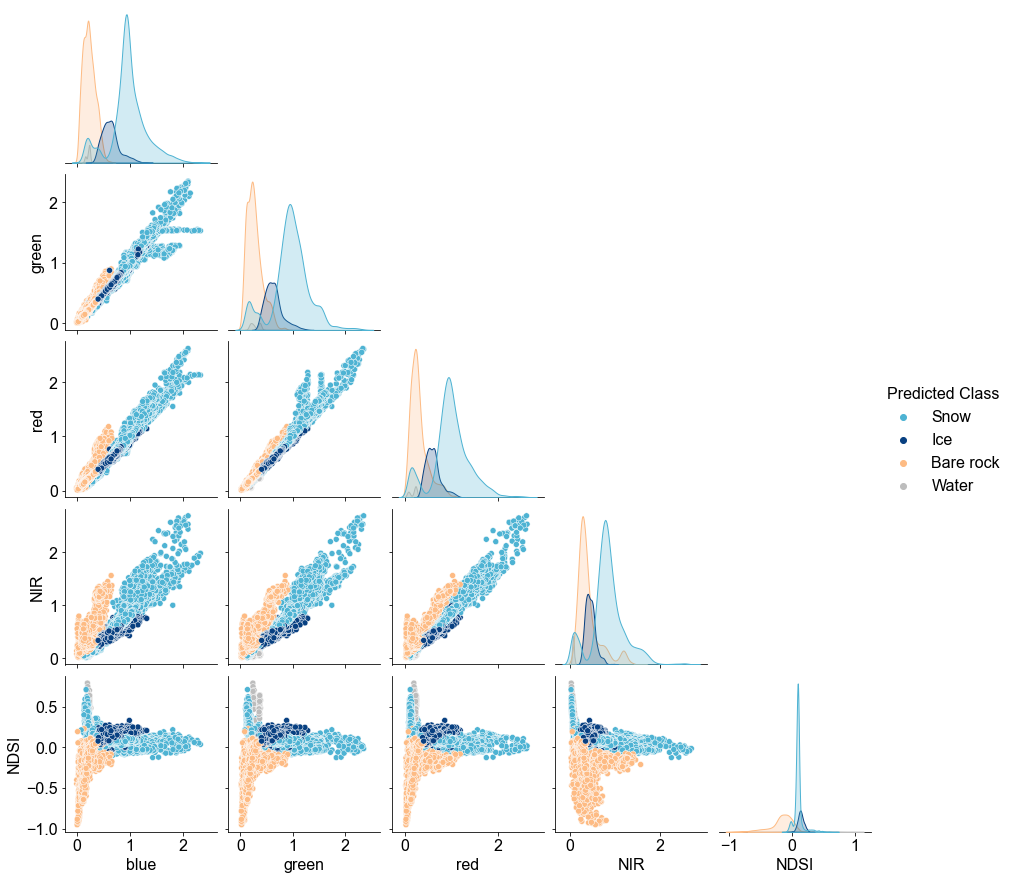

figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/figures/spectral_pairplot_PS_predicted.png


In [72]:
# -----Plot spectral pairplot for predicted values
# Grab predicted values for training data
df = data_pts_full_PS[feature_cols_PS]
df['Predicted Class'] = clf_best.predict(X)
# Assign labels to each class
df.loc[df['Predicted Class']==1, 'Predicted Class'] = 'Snow'
df.loc[df['Predicted Class']==2, 'Predicted Class'] = 'Snow'
df.loc[df['Predicted Class']==3, 'Predicted Class'] = 'Ice'
df.loc[df['Predicted Class']==4, 'Predicted Class'] = 'Bare rock'
df.loc[df['Predicted Class']==5, 'Predicted Class'] = 'Water'
# Create colormap
color_snow = '#4eb3d3'
color_ice = '#084081'
color_rock = '#fdbb84'
color_water = '#bdbdbd'
color_contour = '#f768a1'
# create colormap
colors = [color_snow, color_ice, color_rock, color_water]
# plot
plt.rcParams.update({'font.size':16, 'font.sans-serif':'Arial'})
fig = sns.pairplot(df, corner=True, diag_kind='kde', hue='Predicted Class', palette=colors)
plt.show()

# save figure
if save_figures:
    fig_fn = base_path + 'figures/spectral_pairplot_PS_predicted.png'
    fig.savefig(fig_fn, facecolor='w', dpi=300)
    print('figure saved to file:' + fig_fn)


In [ ]:
# Rearrange confusion matrix to combine snow and snow_shadowed
CM_copy = pd.DataFrame(columns=['Snow', 'Shadowed_snow', 'Ice', 'Bare_ground', 'Water', 'All_snow'])
CM_copy['Snow'] = CM[:,0,0]
CM_copy['Shadowed_snow'] = CM[:,1,0]
CM_copy['Ice'] = CM[:,2,0]
CM_copy['Bare_ground'] = CM[:,3,0]
CM_copy['Water'] = CM[:,4,0]
CM_copy['All_snow'] = CM_copy['Snow'] + CM_copy['Shadowed_snow']
CM_copy = CM_copy.drop(columns=['Snow', 'Shadowed_snow'])
# CM_copy.iloc[[0, 1]] = np.nansum(CM_copy.iloc[[0, 1]])
# CM_copy['Total'] = np.nansum(CM)

print(CM[:,:,0])
print(CM_copy)

### d. Test how the number of points used to train impacts model accuracies

In [ ]:
# -----Test supervised classification algorithms
X = data_pts_full_PS[feature_cols_PS] # features
y = data_pts_full_PS['class'].astype(int) # labels

# Iterate over classifiers
accuracy = np.zeros(len(classifiers)) # mean accuracy
K = np.zeros(len(classifiers)) # mean Kappa score
num_points_list = np.array([np.round(len(X)*x) for x in np.linspace(0.1, 1.0, num=20)], dtype=int)
j=0
for name, clf in zip(names, classifiers):
    
    print(name)

    # initialize vectors
    accuracies = np.zeros(len(num_points_list)) # accuracy for all simulations
    Ks = np.zeros(len(num_points_list)) # kappa score for all MC simulations
    # enumerate the splits and summarize the distributions
    for k, num_points in enumerate(num_points_list):

        # select random rows 
        I = np.random.randint(low=1, high=len(X), size=num_points, dtype=int)
        Isplit = int(np.round(len(I)*0.8)) # index where to split training and testing
        I_train, I_test = I[0:Isplit], I[Isplit:] # indices for pulling training and testing data
        X_train, X_test = X.loc[I_train], X.loc[I_test] # features
        y_train, y_test = y.loc[I_train], y.loc[I_test] # labels

        # Train classifier
        clf.fit(X_train, y_train)

        # Predict class values using trained classifier
        y_pred = clf.predict(X_test)

        # Calculate overall accuracy
        accuracies[k] = metrics.accuracy_score(y_test, y_pred)
        # Calculate Kappa score
        Ks[k] = metrics.cohen_kappa_score(y_test, y_pred)
        # Calculate confusion matrix
        # CM_folds[:, :, k] = metrics.confusion_matrix(y_test, y_pred)
        
    # Calculate mean accuracy and Kappa score
    accuracy[j] = np.nanmean(accuracies)
    K[j] = np.nanmean(Ks)

    # Plot results
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    ax.set_xlabel('Number of points used to train classifier')
    ax.grid()
    ax.plot(num_points_list, accuracies, '.-b', label='Accuracy')
    ax.plot(num_points_list, Ks, '*-m', label='Kappa score')
    ax.legend()
    ax.set_title(name)
    plt.show()
    
    j+=1


## 2. Landsat

### a. Set-up training data

In [74]:
dataset = 'Landsat'
ds_dict = dataset_dict[dataset]

# -----Define bands and feature columns (predictors used in classification)
# Landsat 8 bands: 
# SR_B2=Blue, SR_B3=Green, SR_B4=Red, SR_B5=NIR, SR_B6=SWIR1, SR_B7=SWIR2
band_names = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'QA_PIXEL']
feature_cols_L = band_names[0:-1] + ['NDSI']
# buffer used for clipping images
buffer = 4000 # [m]

# -----Load classified points
os.chdir(data_pts_path)
data_pts_fns = glob.glob('*.shp')
data_pts_fns.sort()

# -----Check if training data exist in file
L_training_data_fn = 'L_training_data.pkl'
if os.path.exists(out_path + L_training_data_fn):
    
    data_pts_full_L = pd.read_pickle(out_path + L_training_data_fn)
    print('Landsat training data already exist... loaded from file.')
    
else: 
    
    # Initialize full data points dataframe (for use in next step)
    data_pts_full_L = data_pts_full_PS.copy(deep=True)
    # remove PS bands
    data_pts_full_L = data_pts_full_L.drop(columns=['blue', 'green', 'red', 'NIR', 'NDSI'])
    # initialize band columns
    data_pts_full_L['L_im_date'] = ' '
    data_pts_full_L[feature_cols_L] = 0

    # Loop through sites
    for i, site_name in enumerate(site_names):

        print('----------')
        print(site_name)
        print('----------')

        # Extract image dates from data point file names
        im_dates = [s[len(site_name)+1:len(site_name)+9] for s in data_pts_fns if (site_name in s) and ('snow.shp' in s)]

        # Load AOI
        AOI_fn = AOI_path + site_name + '/glacier_outlines/' + site_name + '_USGS_*.shp'
        AOI_fn = glob.glob(AOI_fn)[0]
        AOI = gpd.read_file(AOI_fn)
        # reproject AOI to WGS 84 for compatibility with images
        AOI_WGS = AOI.to_crs(4326)
        # reformat AOI_WGS bounding box as ee.Geometry for clipping images
        AOI_WGS_bb_ee = ee.Geometry.Polygon(
                                [[[AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]]]
                                ])

        # Load images from Earth Engine
        if site_name=='Gulkana':
            im1_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_067016_20210610'
            im2_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_068016_20210804'
        elif site_name=='SouthCascade':
            im1_fn= 'LANDSAT/LC08/C02/T1_L2/LC08_046026_20210709'
            im2_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_045026_20210819'
        elif site_name=='Sperry':
            im1_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_041026_20210706'
            im2_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_041026_20210722'
        elif site_name=='Wolverine':
            im1_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_067018_20220629'
            im2_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_067018_20210829'
        im1, im2 = ee.Image(im1_fn), ee.Image(im2_fn)

        # Clip images and select bands
        im1_clip = im1.clip(AOI_WGS_bb_ee.buffer(buffer)).select(band_names)
        im2_clip = im2.clip(AOI_WGS_bb_ee.buffer(buffer)).select(band_names)

        # Determine optimal UTM zone EPSG code
        epsg_UTM = f.convert_wgs_to_utm((AOI_WGS.geometry.bounds.maxx[0] - AOI_WGS.geometry.bounds.minx[0]) + AOI_WGS.geometry.bounds.minx[0],
                                         (AOI_WGS.geometry.bounds.maxy[0] - AOI_WGS.geometry.bounds.miny[0]) + AOI_WGS.geometry.bounds.miny[0])

        # Convert images to xarray Datasets
        im1_xr = im1_clip.wx.to_xarray(scale=20, crs='EPSG:4326')
        im2_xr = im2_clip.wx.to_xarray(scale=20, crs='EPSG:4326')
        # Reproject to UTM
        im1_xr = im1_xr.rio.reproject('EPSG:'+epsg_UTM)
        im2_xr = im2_xr.rio.reproject('EPSG:'+epsg_UTM)
        # Replace no data values with NaN and account for image scalar
        im1_xr = xr.where(im1_xr!=ds_dict['no_data_value'],
                          im1_xr / ds_dict['SR_scalar'],
                          np.nan)
        im2_xr = xr.where(im2_xr!=ds_dict['no_data_value'],
                          im2_xr / ds_dict['SR_scalar'],
                          np.nan)
        # Create list of images
        im_list = [im1_xr, im2_xr]

        # Loop through image dates
        for j, im_date in enumerate(im_dates):

            im = im_list[j]

            # mask clouds
            bands = [str(x) for x in im.data_vars]
            im_mask = f.Landsat_mask_clouds(im, bands, plot_results=False)

            # select df columns for study site and image date
            data_pts = data_pts_full_L.loc[(data_pts_full_L['site_name']==site_name) 
                                            & (data_pts_full_L['PS_im_date']==im_date[0:4]+'-'+im_date[4:6]+'-'+im_date[6:8])]
            # add image date
            data_pts['L_im_date'] = str(im.time.data[0])[0:10]
            # reproject to UTM
            data_pts = data_pts.to_crs(epsg_UTM)
            
            # grab x and y coordinates for data points at the site
            data_pts_x = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].x
                          for i in np.arange(0,len(data_pts))]
            data_pts_y = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].y
                          for i in np.arange(0,len(data_pts))]
            # extract band values at data points 
            for band_name in band_names:
                data_pts[band_name] = [im_mask.sel(x=x, y=y, method="nearest")[band_name].data[0] 
                                       for x, y in list(zip(data_pts_x, data_pts_y))]

            # add data_pts back to full df
            data_pts_full_L.loc[(data_pts_full_L['site_name']==site_name) 
                                 & (data_pts_full_L['PS_im_date']==im_date[0:4]+'-'+im_date[4:6]+'-'+im_date[6:8])] = data_pts

            # plot images and data points
            fig1, ax1 = plt.subplots(1, 1, figsize=(16,16))
            ax1.imshow(np.dstack([im_mask['SR_B4'].data[0], im_mask['SR_B3'].data[0], im_mask['SR_B2'].data[0]]),
                      extent=(np.min(im_mask.x.data)/1e3, np.max(im_mask.x.data)/1e3, 
                              np.min(im_mask.y.data)/1e3, np.max(im_mask.y.data)/1e3))
            ax1.scatter([x.geoms[0].x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1]], 
                        [x.geoms[0].y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1]], c='cyan', s=1)
            ax1.scatter([x.geoms[0].x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==3]], 
                        [x.geoms[0].y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==3]], c='blue', s=1)
            ax1.scatter([x.geoms[0].x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==4]], 
                        [x.geoms[0].y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==4]], c='orange', s=1)
            ax1.scatter([x.geoms[0].x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==5]], 
                        [x.geoms[0].y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==5]], c='grey', s=1)
            ax1.set_xlabel('Easting [km]')
            ax1.set_ylabel('Northing [km]')
            plt.show()

    # Remove no data points
    data_pts_full_L = data_pts_full_L.dropna().reset_index(drop=True)

    # Add NDSI column (G-SWIR)/(G+SWIR)
    NDSI_bands = dataset_dict[dataset]['NDSI']
    data_pts_full_L['NDSI'] = ((data_pts_full_L[NDSI_bands[0]] - data_pts_full_L[NDSI_bands[1]]) 
                             / (data_pts_full_L[NDSI_bands[0]] + data_pts_full_L[NDSI_bands[1]]))

    # don't use shadowed snow (where class==shadowed snow, make it snow)
    data_pts_full_L.loc[data_pts_full_L['class']==2, 'class'] = 1
                              
    # Reduce memory usage in df
    data_pts_full_L = f.reduce_memory_usage(data_pts_full_L)

    # Save training data to file
    data_pts_full_L.to_pickle(out_path + L_training_data_fn)
    print('Landsat training data saved to file:' + out_path + L_training_data_fn)

    # Save feature columns
    feature_cols_fn = out_path + 'L_feature_cols.pkl'
    pickle.dump(feature_cols_L, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: ', feature_cols_fn)

Landsat training data already exist... loaded from file.


#### Plot pairplot of training data spectral characteristics

/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_1019/508233867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Class'] = data_pts_full_L['class'].astype(object)


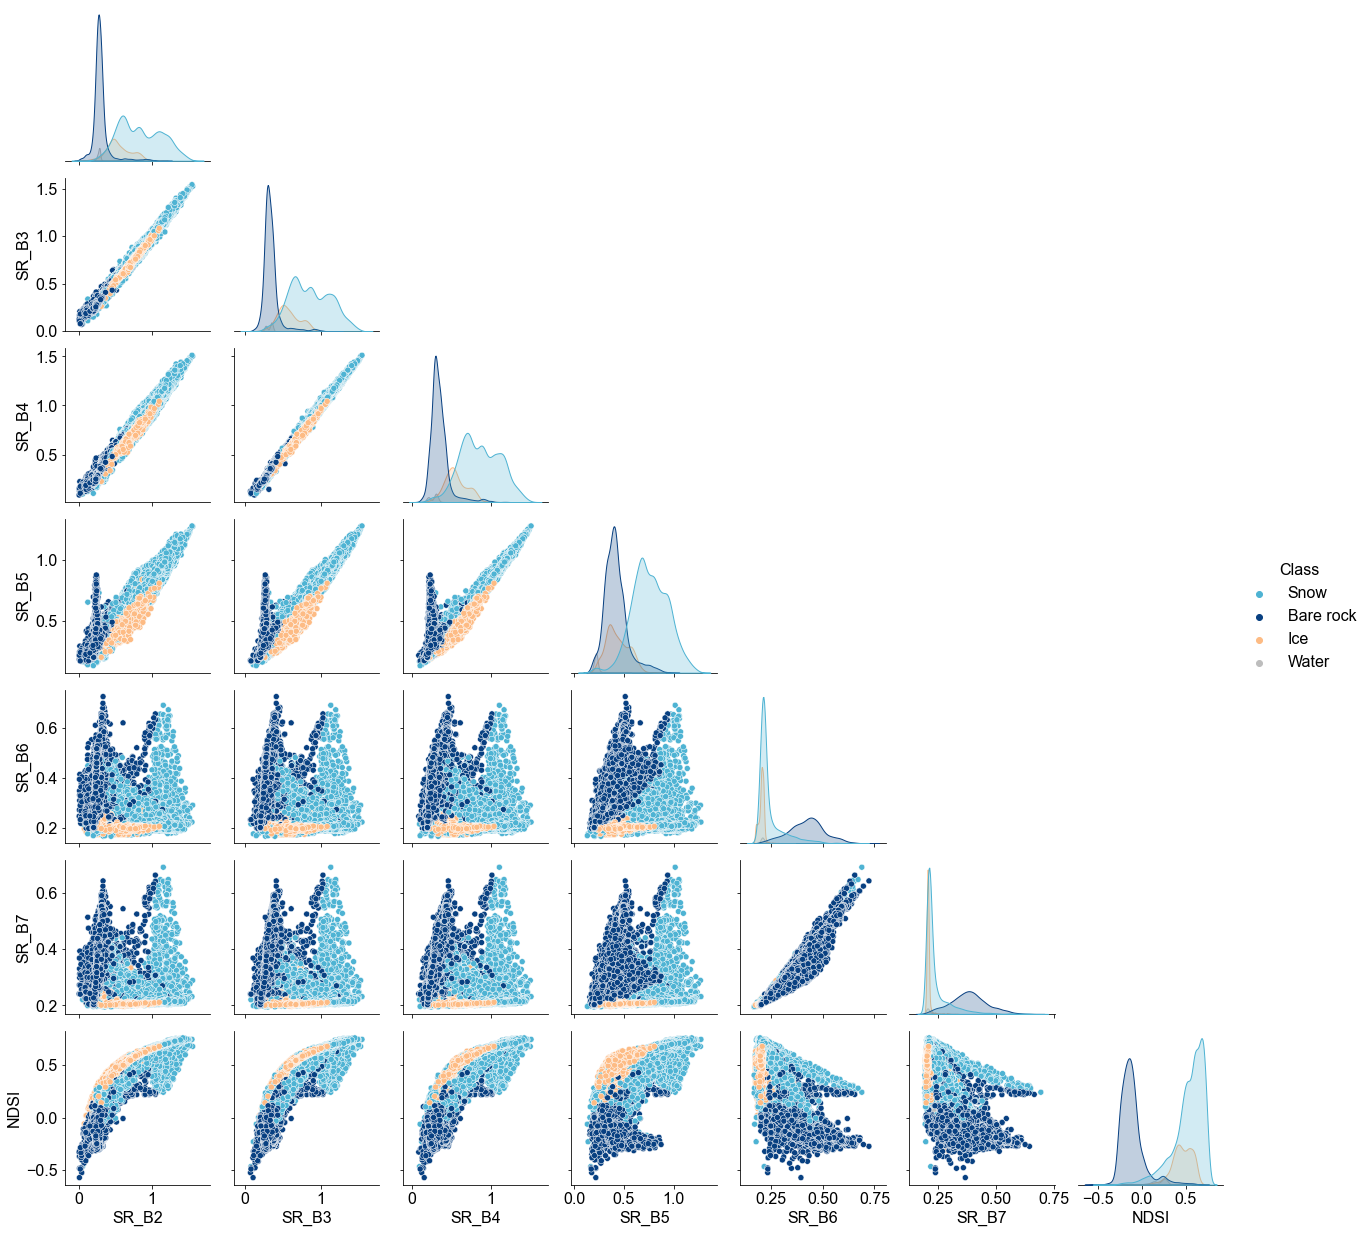

figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/figures/spectral_pairplot_L.png


In [79]:
# Grab predicted values for training data
df = data_pts_full_L[feature_cols_L]
df['Class'] = data_pts_full_L['class'].astype(object)
# Assign labels to each class
df.loc[df['Class']==1, 'Class'] = 'Snow'
df.loc[df['Class']==3, 'Class'] = 'Ice'
df.loc[df['Class']==4, 'Class'] = 'Bare rock'
df.loc[df['Class']==5, 'Class'] = 'Water'
# Create colormap
color_snow = '#4eb3d3'
color_ice = '#084081'
color_rock = '#fdbb84'
color_water = '#bdbdbd'
colors = [color_snow, color_ice, color_rock, color_water]
# plot
plt.rcParams.update({'font.size':16, 'font.sans-serif':'Arial'})
fig = sns.pairplot(df, corner=True, diag_kind='kde', hue='Class', palette=colors)
plt.show()

# save figure
if save_figures:
    fig_fn = base_path + 'figures/spectral_pairplot_L.png'
    fig.savefig(fig_fn, facecolor='w', dpi=300)
    print('figure saved to file:' + fig_fn)

### b. Test one classifier for _each_ site

In [10]:
# -----Test supervised classification algorithms
# Loop through sites
for i, site_name in enumerate(site_names):
    
    print('----------')
    print(site_name)
    print('----------')
 
    # Select all columns in data_pts_full_PS for site
    data_pts = data_pts_full_L.loc[data_pts_full_L['site_name']==site_name]
    
    # don't include shadowed snow
    data_pts.loc[data_pts['class']==2, 'class'] = 1
    data_pts = data_pts.reset_index(drop=True)
    
    # Split data points into features (band values / terrain parameters) and target variable (class)
    X = data_pts[feature_cols_L] # features
    y = data_pts['class'] # target variable
    y = y.astype(int)
    
    # Iterate over classifiers
    accuracy = np.zeros(len(classifiers)) # mean accuracy
    K = np.zeros(len(classifiers)) # mean Kappa score
    j=0
    for name, clf in zip(names, classifiers):
    
        # Conduct K-Fold cross-validation
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
        accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
        K_folds = np.zeros(num_folds) # kappa score for all MC simulations
        k=0 # iteration counter
        # enumerate the splits and summarize the distributions
        for train_ix, test_ix in kfold.split(X):
            
            # select rows
            X_train, X_test = X.loc[train_ix], X.loc[test_ix]
            y_train, y_test = y[train_ix], y[test_ix]
            
            # Train classifier
            clf.fit(X_train, y_train)

            # Predict class values using trained classifier
            y_pred = clf.predict(X_test)

            # Calculate overall accuracy
            accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
            # Calculate Kappa score
            K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)
            
            k+=1
        
        # Calculate mean accuracy and Kappa score
        accuracy[j] = np.nanmean(accuracy_folds)
        K[j] = np.nanmean(K_folds)
        
        j+=1

    # Determine best classifier based on accuracy
    results = pd.DataFrame()
    results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
    clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
    clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
    print(results)
    print('')
    print('Best accuracy classifier: ' + clf_best_name)

    # -----Save most accurate classifier
    if save_outputs==True:
        clf_fn = out_path + 'L_classifier_'+site_names[i]+'.sav'
        pickle.dump(clf_best, open(clf_fn, 'wb'))
        print('Most accurate classifier saved to file: ',clf_fn)

----------
Gulkana
----------
            Classifier  Accuracy  Kappa_score
0    Nearest Neighbors  0.982570     0.970995
1              RBF SVM  0.974507     0.957642
2        Decision Tree  0.967719     0.946429
3        Random Forest  0.968048     0.946896
4           Neural Net  0.966435     0.944182
5             AdaBoost  0.793416     0.674073
6          Naive Bayes  0.956749     0.928070
7                  QDA  0.972246     0.953796
8  Logistic Regression  0.964496     0.940925

Best accuracy classifier: Nearest Neighbors
----------
SouthCascade
----------
            Classifier  Accuracy  Kappa_score
0    Nearest Neighbors  0.965667     0.943343
1              RBF SVM  0.959667     0.933182
2        Decision Tree  0.960000     0.933784
3        Random Forest  0.958333     0.931046
4           Neural Net  0.950333     0.917687
5             AdaBoost  0.654000     0.534743
6          Naive Bayes  0.930667     0.887853
7                  QDA  0.962333     0.938263
8  Logistic Regr

### c. Test one classifier for _all_ sites

In [80]:
# -----Test supervised classification algorithms
data_pts_full_L = data_pts_full_L.reset_index(drop=True)
# don't use shadowed snow
data_pts = data_pts_full_L
data_pts.loc[data_pts['class']==2, 'class'] = 1
X = data_pts[feature_cols_L] # features
y = data_pts['class'] # target variable
y = y.astype(int)
    
# Iterate over classifiers
accuracy = np.zeros(len(classifiers)) # mean accuracy
K = np.zeros(len(classifiers)) # mean Kappa score
j=0
for name, clf in zip(names, classifiers):
    
    print(name)

    # Conduct K-Fold cross-validation
    num_folds = 10
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
    accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
    K_folds = np.zeros(num_folds) # kappa score for all MC simulations
    k=0 # iteration counter
    # enumerate the splits and summarize the distributions
    for train_ix, test_ix in kfold.split(X):

        # select rows
        X_train, X_test = X.loc[train_ix], X.loc[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        # Train classifier
        clf.fit(X_train, y_train)

        # Predict class values using trained classifier
        y_pred = clf.predict(X_test)

        # Calculate overall accuracy
        accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
        # Calculate Kappa score
        K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)

        k+=1
        
    # Calculate mean accuracy and Kappa score
    accuracy[j] = np.nanmean(accuracy_folds)
    K[j] = np.nanmean(K_folds)

    j+=1

# Determine best classifier based on accuracy
results = pd.DataFrame()
results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
#     results['TP'], results['TN'], results['FP'], results['FN'] = TP, TN, FP, FN
clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
print(results)
print('')
print('Best accuracy classifier: ' + clf_best_name)

# -----Save most accurate classifier
if save_outputs==True:
    clf_fn = out_path+'L_classifier_all_sites.sav'
    pickle.dump(clf_best, open(clf_fn, 'wb'))
    print('Most accurate classifier saved to file: ',clf_fn)

Nearest Neighbors
RBF SVM
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
Logistic Regression


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

            Classifier  Accuracy  Kappa_score
0    Nearest Neighbors  0.947781     0.912648
1              RBF SVM  0.938692     0.897808
2        Decision Tree  0.929851     0.881803
3        Random Forest  0.929107     0.880854
4           Neural Net  0.896883     0.824706
5             AdaBoost  0.793255     0.675057
6          Naive Bayes  0.829544     0.731727
7                  QDA  0.932991     0.888937
8  Logistic Regression  0.911013     0.849950

Best accuracy classifier: Nearest Neighbors


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_1019/102277819.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Predicted Class'] = clf_best.predict(X)
/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_1019/102277819.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['Predicted Class']==1, 'Predicted Class'] = 'Snow'


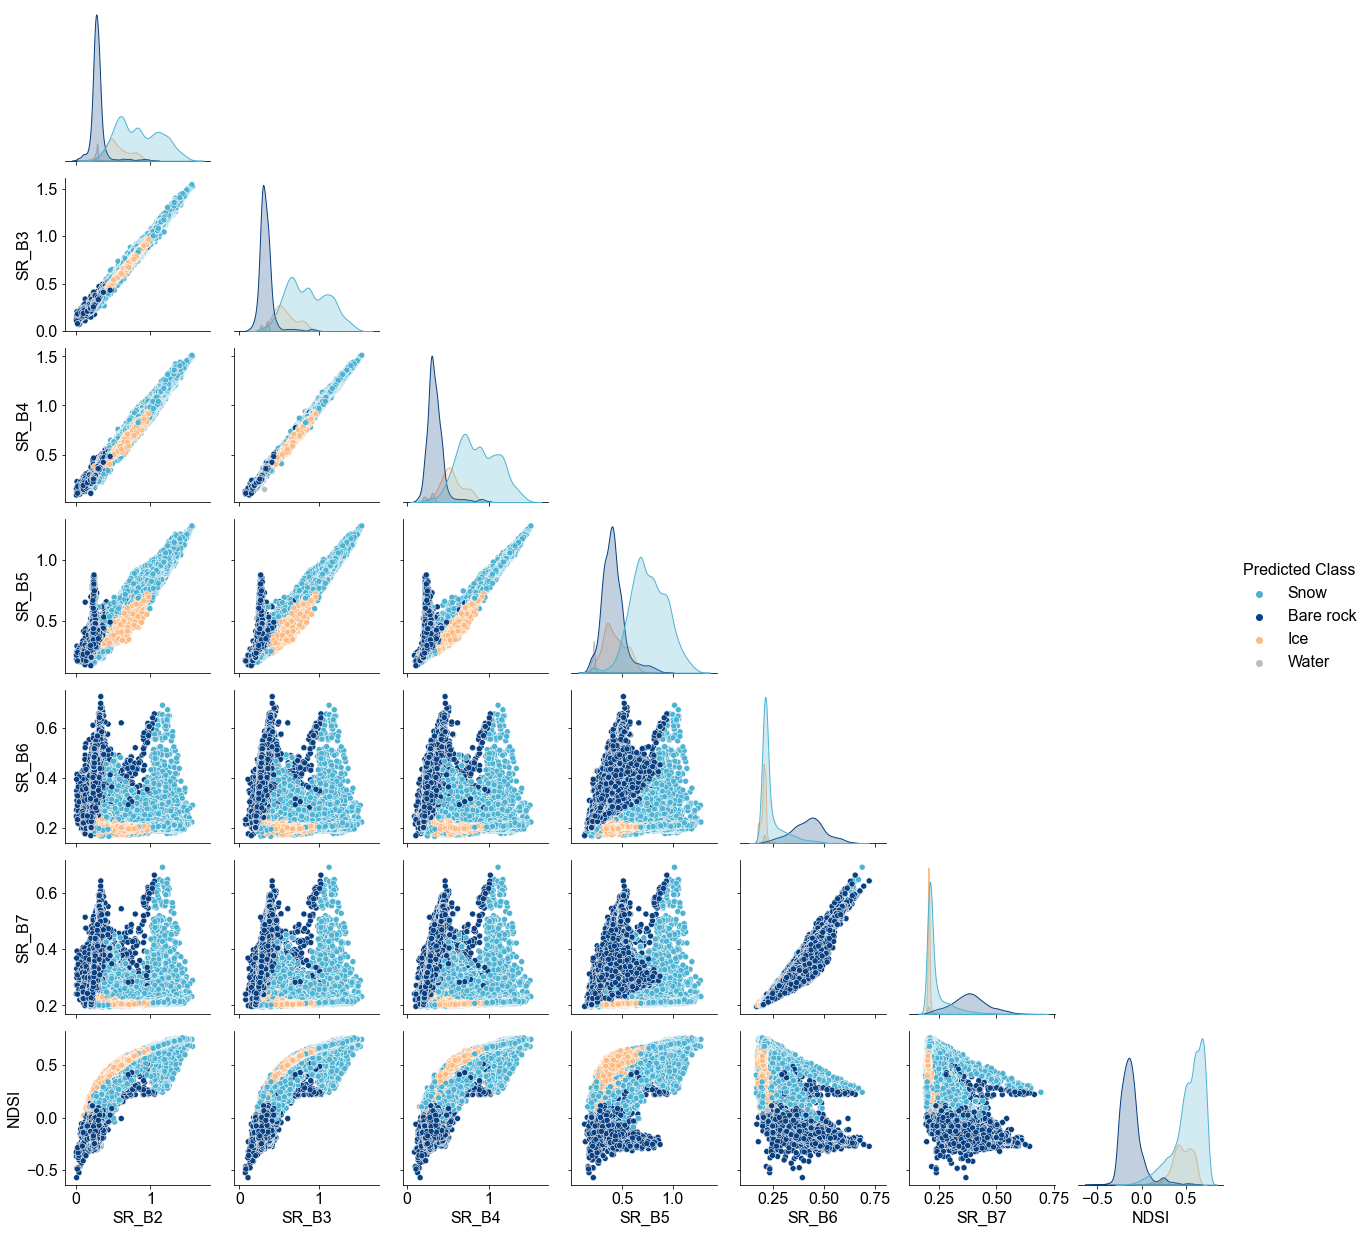

figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/figures/spectral_pairplot_L_predicted.png


In [81]:
# -----Plot spectral pairplot for predicted values
# Grab predicted values for training data
df = data_pts_full_L[feature_cols_L]
df['Predicted Class'] = clf_best.predict(X)
# Assign labels to each class
df.loc[df['Predicted Class']==1, 'Predicted Class'] = 'Snow'
df.loc[df['Predicted Class']==3, 'Predicted Class'] = 'Ice'
df.loc[df['Predicted Class']==4, 'Predicted Class'] = 'Bare rock'
df.loc[df['Predicted Class']==5, 'Predicted Class'] = 'Water'
# Create colormap
color_snow = '#4eb3d3'
color_ice = '#084081'
color_rock = '#fdbb84'
color_water = '#bdbdbd'
color_contour = '#f768a1'
# create colormap
colors = [color_snow, color_ice, color_rock, color_water]
# plot
plt.rcParams.update({'font.size':16, 'font.sans-serif':'Arial'})
fig = sns.pairplot(df, corner=True, diag_kind='kde', hue='Predicted Class', palette=colors)
plt.show()

# save figure
if save_figures:
    fig_fn = base_path + 'figures/spectral_pairplot_L_predicted.png'
    fig.savefig(fig_fn, facecolor='w', dpi=300)
    print('figure saved to file:' + fig_fn)

### d. Test how the number of points used to train impacts model accuracies

In [ ]:
# -----Test supervised classification algorithms
X = data_pts_full_L[feature_cols_L] # features
y = data_pts_full_L['class'].astype(int) # labels

# Iterate over classifiers
accuracy = np.zeros(len(classifiers)) # mean accuracy
K = np.zeros(len(classifiers)) # mean Kappa score
num_points_list = np.array([np.round(len(X)*x) for x in np.linspace(0.1, 1.0, num=20)], dtype=int)
j=0
for name, clf in zip(names, classifiers):
    
    print(name)

    # initialize vectors
    accuracies = np.zeros(len(num_points_list)) # accuracy for all simulations
    Ks = np.zeros(len(num_points_list)) # kappa score for all MC simulations
    # enumerate the splits and summarize the distributions
    for k, num_points in enumerate(num_points_list):

        # select random rows 
        I = np.random.randint(low=1, high=len(X), size=num_points, dtype=int)
        Isplit = int(np.round(len(I)*0.8)) # index where to split training and testing
        I_train, I_test = I[0:Isplit], I[Isplit:] # indices for pulling training and testing data
        X_train, X_test = X.loc[I_train], X.loc[I_test] # features
        y_train, y_test = y.loc[I_train], y.loc[I_test] # labels

        # Train classifier
        clf.fit(X_train, y_train)

        # Predict class values using trained classifier
        y_pred = clf.predict(X_test)

        # Calculate overall accuracy
        accuracies[k] = metrics.accuracy_score(y_test, y_pred)
        # Calculate Kappa score
        Ks[k] = metrics.cohen_kappa_score(y_test, y_pred)
        # Calculate confusion matrix
        # CM_folds[:, :, k] = metrics.confusion_matrix(y_test, y_pred)
        
    # Calculate mean accuracy and Kappa score
    accuracy[j] = np.nanmean(accuracies)
    K[j] = np.nanmean(Ks)

    # Plot results
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    ax.set_xlabel('Number of points used to train classifier')
    ax.grid()
    ax.plot(num_points_list, accuracies, '.-b', label='Accuracy')
    ax.plot(num_points_list, Ks, '*-m', label='Kappa score')
    ax.legend()
    ax.set_title(name)
    plt.show()
    
    j+=1


## 3. Sentinel-2 SR

### a. Set-up training data

In [82]:
dataset='Sentinel2_SR'
ds_dict = dataset_dict[dataset]

# -----Define bands and feature columns (predictors used in classification)
# Sentinel-2 bands: 
# B2=Blue, B3=Green, B4=Red, B5=Red Edge 1, B6=Red Edge 2, B7=Red Edge 3, B8=NIR, 
# B8A=Red Edge 4, B9=Water vapor, B11=SWIR1, B12=SWIR2
band_names = [band for band in ds_dict['bands'] if 'QA' not in band]
feature_cols_S2 = band_names + ['NDSI']
# buffer used for clipping images
buffer = [1000, 3000, 1000, 2500] # [m]

# -----Check if training data exist in file
S2_training_data_fn = 'S2_SR_training_data.pkl'
if os.path.exists(out_path + S2_training_data_fn):
    
    data_pts_full_S2 = pd.read_pickle(out_path + S2_training_data_fn)
    print('S2 training data already exist... loaded from file.')
    
else: 
    
    # Initialize full data points dataframe (for use in next step)
    data_pts_full_S2 = data_pts_full_PS.copy(deep=True)
    data_pts_full_S2 = data_pts_full_S2.drop(columns=['blue', 'red', 'green', 'NIR', 'NDSI'])
    data_pts_full_S2[band_names] = " " # initialize band columns

    # Loop through sites
    for i, site_name in enumerate(site_names):
    
        print('----------')
        print(site_name)
        print('----------')

        # Extract image dates from data point file names
        im_dates = [s[len(site_name)+1:len(site_name)+9] for s in data_pts_fns if (site_name in s) and ('snow.shp' in s)]

        # Load AOI
        AOI_fn = AOI_path + site_name + '/glacier_outlines/' + site_name + '_USGS_*.shp'
        AOI_fn = glob.glob(AOI_fn)[0]
        AOI = gpd.read_file(AOI_fn)
        # reproject AOI to WGS 84 for compatibility with images
        AOI_WGS = AOI.to_crs(4326)
        # reformat AOI_WGS bounding box as ee.Geometry for clipping images
        AOI_WGS_bb_ee = ee.Geometry.Polygon(
                                [[[AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]]]
                                ])

        # Load images from Earth Engine
        if site_name=='Gulkana':
            im1_fn = '20210615T211519_20210615T211514_T06VWR'
            im2_fn = '20210802T212531_20210802T212655_T06VWR'
        elif site_name=='SouthCascade':
            im1_fn= '20210704T190921_20210704T191755_T10UFU'
            im2_fn = '20210825T185919_20210825T190431_T10UFU'
        elif site_name=='Sperry':
            im1_fn = '20210630T183919_20210630T184143_T11UQP'
            im2_fn = '20210730T183919_20210730T184810_T11UQP'
        elif site_name=='Wolverine':
            im1_fn = '20210615T211519_20210615T211514_T06VUN'
            im2_fn = '20210829T211521_20210829T211714_T06VUN'
        im1, im2 = ee.Image('COPERNICUS/S2_SR_HARMONIZED/'+im1_fn), ee.Image('COPERNICUS/S2_SR_HARMONIZED/'+im2_fn)
        # Clip images and select bands
        im1_clip = im1.clip(AOI_WGS_bb_ee.buffer(buffer[i])).select(band_names)
        im2_clip = im2.clip(AOI_WGS_bb_ee.buffer(buffer[i])).select(band_names)
        
        # Convert images to xarray Datasets
        im1_xr = im1_clip.wx.to_xarray(scale=20, crs='EPSG:4326')
        im2_xr = im2_clip.wx.to_xarray(scale=20, crs='EPSG:4326')
        # Determine optimal UTM zone EPSG code
        epsg_UTM = f.convert_wgs_to_utm((AOI_WGS.geometry.bounds.maxx[0] - AOI_WGS.geometry.bounds.minx[0]) + AOI_WGS.geometry.bounds.minx[0],
                                         (AOI_WGS.geometry.bounds.maxy[0] - AOI_WGS.geometry.bounds.miny[0]) + AOI_WGS.geometry.bounds.miny[0])
        # Reproject to UTM
        im1_xr = im1_xr.rio.reproject('EPSG:'+epsg_UTM)
        im2_xr = im2_xr.rio.reproject('EPSG:'+epsg_UTM)
        # Replace no data values with NaN, account for image scalar
        im1_xr = xr.where(im1_xr!=ds_dict['no_data_value'], 
                          im1_xr / ds_dict['SR_scalar'], 
                          np.nan)
        im2_xr = xr.where(im2_xr!=ds_dict['no_data_value'], 
                          im2_xr / ds_dict['SR_scalar'], 
                          np.nan)
        # Create list of images
        im_list = [im1_xr, im2_xr]
        
        # Loop through image dates
        for j, im_date in enumerate(im_dates):

            im = im_list[j]
            
            # select df columns for study site and image date
            data_pts = data_pts_full_S2.loc[(data_pts_full_S2['site_name']==site_name) 
                                            & (data_pts_full_S2['PS_im_date']==im_date[0:4]+'-'+im_date[4:6]+'-'+im_date[6:8])]
            # reproject to UTM
            data_pts = data_pts.to_crs(epsg_UTM)
            
            # grab x and y coordinates for data points at the site
            data_pts_x = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].x
                          for i in np.arange(0,len(data_pts))]
            data_pts_y = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].y
                          for i in np.arange(0,len(data_pts))]
            
            # extract band values at data points 
            for band_name in band_names:
                data_pts[band_name] = [im.sel(x=x, y=y, method="nearest")[band_name].data[0] 
                                       for x, y in list(zip(data_pts_x, data_pts_y))]

            # plot images and data points
            fig1, ax1 = plt.subplots(1, 1, figsize=(6,6))
            ax1.imshow(np.dstack([im['B4'].data[0], im['B3'].data[0], im['B2'].data[0]]),
                      extent=(np.min(im.x.data)/1e3, np.max(im.x.data)/1e3, 
                              np.min(im.y.data)/1e3, np.max(im.y.data)/1e3))
            # ax1.scatter([x.geoms[0].x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1]], 
            #             [x.geoms[0].y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1]], c='cyan', s=2)
            ax1.plot([x/1e3 for x in data_pts_x], [y/1e3 for y in data_pts_y], '.m', markersize=5)
            ax1.set_xlabel('Easting [km]')
            ax1.set_ylabel('Northing [km]')
            plt.show()

            # add data_pts back to full df
            data_pts_full_S2.loc[(data_pts_full_S2['site_name']==site_name) 
                                 & (data_pts_full_S2['PS_im_date']==im_date[0:4]+'-'+im_date[4:6]+'-'+im_date[6:8])] = data_pts

    # Add NDSI column
    data_pts_full_S2['NDSI'] = ((data_pts_full_S2[ds_dict['NDSI'][0]] - data_pts_full_S2[ds_dict['NDSI'][1]]) / 
                                (data_pts_full_S2[ds_dict['NDSI'][0]] + data_pts_full_S2[ds_dict['NDSI'][1]]))
    
    # Remove no data points
    data_pts_full_S2 = data_pts_full_S2.dropna().reset_index(drop=True)
    
    # don't use shadowed snow (where class==shadowed snow, make it snow)
    data_pts_full_S2.loc[data_pts_full_S2['class']==2, 'class'] = 1
    
    # Reduce memory usage in df
    data_pts_full_S2 = f.reduce_memory_usage(data_pts_full_S2)
    
    # Save training data to file
    data_pts_full_S2.to_pickle(out_path + S2_training_data_fn)
    print('S2 training data saved to file:' + out_path + S2_training_data_fn)
    
    # Save feature columns
    feature_cols_fn = out_path + 'S2_feature_cols.pkl'
    pickle.dump(feature_cols_S2, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: ', feature_cols_fn)

S2 training data already exist... loaded from file.


#### Plot pairplot of training data spectral characteristics

figure saved to file:/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/figures/spectral_pairplot_S2_SR.png


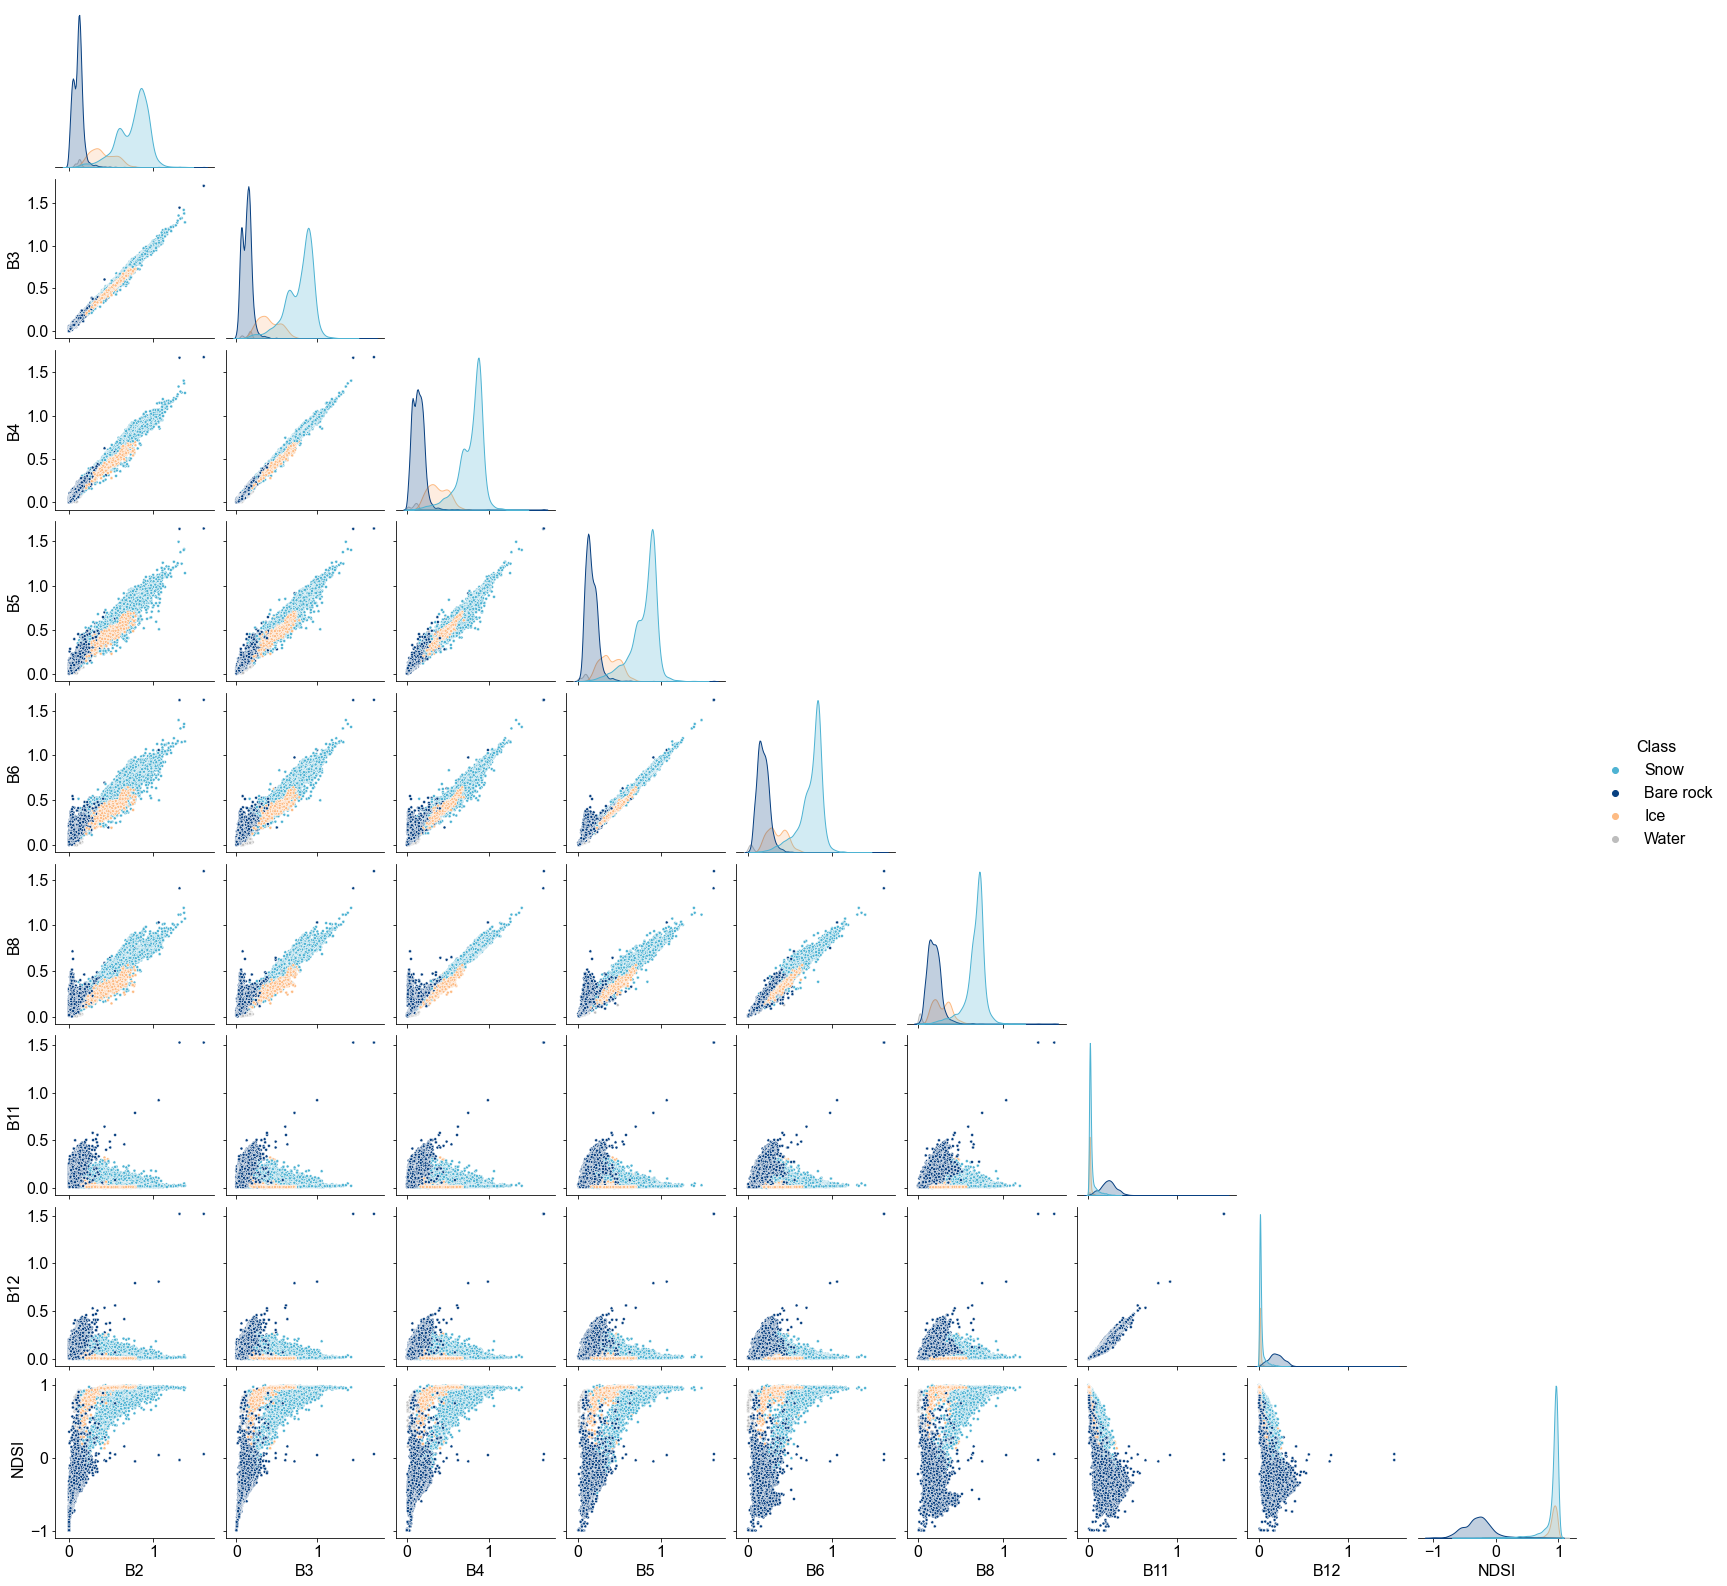

In [85]:
data_pts_full_S2['Class'] = data_pts_full_S2['class'].astype(object)

# Create colormap
color_snow = '#4eb3d3'
color_ice = '#084081'
color_rock = '#fdbb84'
color_water = '#bdbdbd'
color_contour = '#f768a1'
# create colormap
colors = [color_snow, color_ice, color_rock, color_water]
# Assign labels to each class
df = data_pts_full_S2
df.loc[df['Class']==1, 'Class'] = 'Snow'
df.loc[df['Class']==3, 'Class'] = 'Ice'
df.loc[df['Class']==4, 'Class'] = 'Bare rock'
df.loc[df['Class']==5, 'Class'] = 'Water'
# plot
fig = sns.pairplot(data_pts_full_S2[['Class'] + feature_cols_S2], markers='.',  
             corner=True, diag_kind='kde', hue='Class', palette=colors);

# save figure
if save_figures:
    fig_fn = base_path + 'figures/spectral_pairplot_S2_SR.png'
    fig.savefig(fig_fn, facecolor='w', dpi=300)
    print('figure saved to file:' + fig_fn)

### b. Test one classifier for _each_ site

In [12]:
# -----Test supervised classification algorithms
# Loop through sites
for i, site_name in enumerate(site_names):
    
    print('----------')
    print(site_name)
    print('----------')
 
    # Select all columns in data_pts_full_PS for site
    data_pts = data_pts_full_S2.loc[data_pts_full_S2['site_name']==site_name]
    data_pts = data_pts.reset_index(drop=True)
    
    # Split data points into features (band values / terrain parameters) and target variable (class)
    X = data_pts[feature_cols_S2] # features
    y = data_pts['class'] # target variable
    y = y.astype(int)
    
    
    # Iterate over classifiers
    accuracy = np.zeros(len(classifiers)) # mean accuracy
    K = np.zeros(len(classifiers)) # mean Kappa score
    j=0
    for name, clf in zip(names, classifiers):
    
        print(name)
                
        # Conduct K-Fold cross-validation
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
        accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
        K_folds = np.zeros(num_folds) # kappa score for all MC simulations
        k=0 # iteration counter
        # enumerate the splits and summarize the distributions
        for train_ix, test_ix in kfold.split(X):
            
            # select rows
            X_train, X_test = X.loc[train_ix], X.loc[test_ix]
            y_train, y_test = y[train_ix], y[test_ix]
            
            # Train classifier
            clf.fit(X_train, y_train)

            # Predict class values using trained classifier
            y_pred = clf.predict(X_test)

            # Calculate overall accuracy
            accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
            # Calculate Kappa score
            K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)
            
            k+=1

        # Calculate mean accuracy and Kappa score
        accuracy[j] = np.nanmean(accuracy_folds)
        K[j] = np.nanmean(K_folds)
        
        j+=1

    # Determine best classifier based on accuracy
    results = pd.DataFrame()
    results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
    clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
    clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
    print(results)
    print('')
    print('Best accuracy classifier: ' + clf_best_name)

    # -----Save most accurate classifier
    if save_outputs==True:
        clf_fn = out_path + 'S2_SR_classifier_'+site_name+'.sav'
        pickle.dump(clf_best, open(clf_fn, 'wb'))
        print('Most accurate classifier saved to file: ',clf_fn)  

----------
Gulkana
----------
Nearest Neighbors
RBF SVM
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
Logistic Regression
            Classifier  Accuracy  Kappa_score
0    Nearest Neighbors  0.990405     0.984119
1              RBF SVM  0.989449     0.982528
2        Decision Tree  0.990409     0.984104
3        Random Forest  0.990087     0.983633
4           Neural Net  0.989447     0.982537
5             AdaBoost  0.982412     0.970711
6          Naive Bayes  0.988809     0.981473
7                  QDA  0.989769     0.983003
8  Logistic Regression  0.989128     0.982000

Best accuracy classifier: Decision Tree
----------
SouthCascade
----------
Nearest Neighbors
RBF SVM
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
Logistic Regression
            Classifier  Accuracy  Kappa_score
0    Nearest Neighbors  0.981647     0.969853
1              RBF SVM  0.981645     0.969912
2        Decision Tree  0.975308     0.959251
3        Random Forest  0.9756

### c. Test one classifier for _all_ sites

In [86]:
# -----Test supervised classification algorithms
X = data_pts_full_S2[feature_cols_S2] # features
y = data_pts_full_S2['class'] # target variable
y = y.astype(int)
    
# Iterate over classifiers
accuracy = np.zeros(len(classifiers)) # mean accuracy
K = np.zeros(len(classifiers)) # mean Kappa score
j=0
for name, clf in zip(names, classifiers):
    
    print(name)

    # Conduct K-Fold cross-validation
    num_folds = 10
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
    accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
    K_folds = np.zeros(num_folds) # kappa score for all MC simulations
    k=0 # iteration counter
    # enumerate the splits and summarize the distributions
    for train_ix, test_ix in kfold.split(X):

        # select rows
        X_train, X_test = X.loc[train_ix], X.loc[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        # Train classifier
        clf.fit(X_train, y_train)

        # Predict class values using trained classifier
        y_pred = clf.predict(X_test)

        # Calculate overall accuracy
        accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
        # Calculate Kappa score
        K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)

        k+=1
        
    # Calculate mean accuracy and Kappa score
    accuracy[j] = np.nanmean(accuracy_folds)
    K[j] = np.nanmean(K_folds)

    j+=1

# Determine best classifier based on accuracy
results = pd.DataFrame()
results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
#     results['TP'], results['TN'], results['FP'], results['FN'] = TP, TN, FP, FN
clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
print(results)
print('')
print('Best accuracy classifier: ' + clf_best_name)

# -----Save most accurate classifier
if save_outputs==True:
    clf_fn = out_path+'S2_SR_classifier_all_sites.sav'
    pickle.dump(clf_best, open(clf_fn, 'wb'))
    print('Most accurate classifier saved to file: ',clf_fn)

Nearest Neighbors
RBF SVM
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA
Logistic Regression
            Classifier  Accuracy  Kappa_score
0    Nearest Neighbors  0.971049     0.951758
1              RBF SVM  0.966819     0.944872
2        Decision Tree  0.964910     0.941591
3        Random Forest  0.960929     0.934764
4           Neural Net  0.949731     0.915896
5             AdaBoost  0.795873     0.662059
6          Naive Bayes  0.947325     0.913097
7                  QDA  0.971298     0.952099
8  Logistic Regression  0.957279     0.928649

Best accuracy classifier: QDA


In [ ]:
# -----Plot spectral pairplot for predicted values
# Grab predicted values for training data
df = data_pts_full_S2[feature_cols_S2]
df['Predicted Class'] = clf_best.predict(X)
# Assign labels to each class
df.loc[df['Predicted Class']==1, 'Predicted Class'] = 'Snow'
df.loc[df['Predicted Class']==3, 'Predicted Class'] = 'Ice'
df.loc[df['Predicted Class']==4, 'Predicted Class'] = 'Bare rock'
df.loc[df['Predicted Class']==5, 'Predicted Class'] = 'Water'
# Create colormap
color_snow = '#4eb3d3'
color_ice = '#084081'
color_rock = '#fdbb84'
color_water = '#bdbdbd'
color_contour = '#f768a1'
# create colormap
colors = [color_snow, color_ice, color_rock, color_water]
# plot
plt.rcParams.update({'font.size':16, 'font.sans-serif':'Arial'})
fig = sns.pairplot(df, corner=True, diag_kind='kde', hue='Predicted Class', palette=colors)
plt.show()

# save figure
if save_figures:
    fig_fn = base_path + 'figures/spectral_pairplot_L_predicted.png'
    fig.savefig(fig_fn, facecolor='w', dpi=300)
    print('figure saved to file:' + fig_fn)

### d. Test how the number of points used to train impacts model accuracies

In [ ]:
# -----Test supervised classification algorithms
X = data_pts_full_S2[feature_cols_S2] # features
y = data_pts_full_S2['class'].astype(int) # labels

# Iterate over classifiers
accuracy = np.zeros(len(classifiers)) # mean accuracy
K = np.zeros(len(classifiers)) # mean Kappa score
num_points_list = np.array([np.round(len(X)*x) for x in np.linspace(0.1, 1.0, num=20)], dtype=int)
j=0
for name, clf in zip(names, classifiers):
    
    print(name)

    # initialize vectors
    accuracies = np.zeros(len(num_points_list)) # accuracy for all simulations
    Ks = np.zeros(len(num_points_list)) # kappa score for all MC simulations
    # enumerate the splits and summarize the distributions
    for k, num_points in enumerate(num_points_list):

        # select random rows 
        I = np.random.randint(low=1, high=len(X), size=num_points, dtype=int)
        Isplit = int(np.round(len(I)*0.8)) # index where to split training and testing
        I_train, I_test = I[0:Isplit], I[Isplit:] # indices for pulling training and testing data
        X_train, X_test = X.loc[I_train], X.loc[I_test] # features
        y_train, y_test = y.loc[I_train], y.loc[I_test] # labels

        # Train classifier
        clf.fit(X_train, y_train)

        # Predict class values using trained classifier
        y_pred = clf.predict(X_test)

        # Calculate overall accuracy
        accuracies[k] = metrics.accuracy_score(y_test, y_pred)
        # Calculate Kappa score
        Ks[k] = metrics.cohen_kappa_score(y_test, y_pred)
        # Calculate confusion matrix
        # CM_folds[:, :, k] = metrics.confusion_matrix(y_test, y_pred)
        
    # Calculate mean accuracy and Kappa score
    accuracy[j] = np.nanmean(accuracies)
    K[j] = np.nanmean(Ks)

    # Plot results
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    ax.set_xlabel('Number of points used to train classifier')
    ax.grid()
    ax.plot(num_points_list, accuracies, '.-b', label='Accuracy')
    ax.plot(num_points_list, Ks, '*-m', label='Kappa score')
    ax.legend()
    ax.set_title(name)
    plt.show()
    
    j+=1


## 4. Sentinel-2 TOA

In [ ]:
dataset='Sentinel2-TOA'
ds_dict = dataset_dict['Sentinel2_TOA']

# -----Define bands and feature columns (predictors used in classification)
# Sentinel-2 bands: 
# B2=Blue, B3=Green, B4=Red, B5=Red Edge 1, B6=Red Edge 2, B7=Red Edge 3, B8=NIR, 
# B8A=Red Edge 4, B9=Water vapor, B11=SWIR1, B12=SWIR2
band_names = [band for band in ds_dict['bands'] if 'QA' not in band]
feature_cols_S2_TOA = band_names + ['NDSI']
# buffer used for clipping images
buffer = [1000, 3000, 1000, 2500] # [m]

# -----Check if training data exist in file
S2_TOA_training_data_fn = 'S2_TOA_training_data.pkl'
if os.path.exists(out_path + S2_TOA_training_data_fn):
    
    data_pts_full_S2_TOA = pd.read_pickle(out_path + S2_TOA_training_data_fn)
    print('S2-TOA training data already exist... loaded from file.')
    
else: 
    
    # Initialize full data points dataframe (for use in next step)
    data_pts_full_S2_TOA = data_pts_full_PS.copy(deep=True)
    data_pts_full_S2_TOA = data_pts_full_S2_TOA.drop(columns=['blue', 'red', 'green', 'NIR', 'NDSI'])
    data_pts_full_S2_TOA[band_names] = " " # initialize band columns

    # Loop through sites
    for i, site_name in enumerate(site_names):
    
        print('----------')
        print(site_name)
        print('----------')

        # Extract image dates from data point file names
        im_dates = [s[len(site_name)+1:len(site_name)+9] for s in data_pts_fns if (site_name in s) and ('snow.shp' in s)]

        # Load AOI
        AOI_fn = AOI_path + site_name + '/glacier_outlines/' + site_name + '_USGS_*.shp'
        AOI_fn = glob.glob(AOI_fn)[0]
        AOI = gpd.read_file(AOI_fn)
        # reproject AOI to WGS 84 for compatibility with images
        AOI_WGS = AOI.to_crs(4326)
        # reformat AOI_WGS bounding box as ee.Geometry for clipping images
        AOI_WGS_bb_ee = ee.Geometry.Polygon(
                                [[[AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]]]
                                ])

        # Load images from Earth Engine
        if site_name=='Gulkana':
            im1_fn = '20210615T211519_20210615T211514_T06VWR'
            im2_fn = '20210802T212531_20210802T212655_T06VWR'
        elif site_name=='SouthCascade':
            im1_fn= '20210704T190921_20210704T191755_T10UFU'
            im2_fn = '20210825T185919_20210825T190431_T10UFU'
        elif site_name=='Sperry':
            im1_fn = '20210630T183919_20210630T184143_T11UQP'
            im2_fn = '20210730T183919_20210730T184810_T11UQP'
        elif site_name=='Wolverine':
            im1_fn = '20210615T211519_20210615T211514_T06VUN'
            im2_fn = '20210829T211521_20210829T211714_T06VUN'
        im1, im2 = ee.Image('COPERNICUS/S2_HARMONIZED/'+im1_fn), ee.Image('COPERNICUS/S2_HARMONIZED/'+im2_fn)
        # Clip images and select bands
        im1_clip = im1.clip(AOI_WGS_bb_ee.buffer(buffer[i])).select(band_names)
        im2_clip = im2.clip(AOI_WGS_bb_ee.buffer(buffer[i])).select(band_names)
        
        # Convert images to xarray Datasets
        im1_xr = im1_clip.wx.to_xarray(scale=20, crs='EPSG:4326')
        im2_xr = im2_clip.wx.to_xarray(scale=20, crs='EPSG:4326')
        # Determine optimal UTM zone EPSG code
        epsg_UTM = f.convert_wgs_to_utm((AOI_WGS.geometry.bounds.maxx[0] - AOI_WGS.geometry.bounds.minx[0]) + AOI_WGS.geometry.bounds.minx[0],
                                         (AOI_WGS.geometry.bounds.maxy[0] - AOI_WGS.geometry.bounds.miny[0]) + AOI_WGS.geometry.bounds.miny[0])
        # Reproject to UTM
        im1_xr = im1_xr.rio.reproject('EPSG:'+epsg_UTM)
        im2_xr = im2_xr.rio.reproject('EPSG:'+epsg_UTM)
        # Replace no data values with NaN, account for image scalar
        im1_xr = xr.where(im1_xr!=ds_dict['no_data_value'], 
                          im1_xr / ds_dict['SR_scalar'], 
                          np.nan)
        im2_xr = xr.where(im2_xr!=ds_dict['no_data_value'], 
                          im2_xr / ds_dict['SR_scalar'], 
                          np.nan)
        # Create list of images
        im_list = [im1_xr, im2_xr]
        
        # Loop through image dates
        for j, im_date in enumerate(im_dates):

            im = im_list[j]
            
            # select df columns for study site and image date
            data_pts = data_pts_full_S2_TOA.loc[(data_pts_full_S2_TOA['site_name']==site_name) 
                                            & (data_pts_full_S2_TOA['PS_im_date']==im_date[0:4]+'-'+im_date[4:6]+'-'+im_date[6:8])]
            # reproject to UTM
            data_pts = data_pts.to_crs(epsg_UTM)
            
            # grab x and y coordinates for data points at the site
            data_pts_x = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].x
                          for i in np.arange(0,len(data_pts))]
            data_pts_y = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].y
                          for i in np.arange(0,len(data_pts))]
            
            # extract band values at data points 
            for band_name in band_names:
                data_pts[band_name] = [im.sel(x=x, y=y, method="nearest")[band_name].data[0] 
                                       for x, y in list(zip(data_pts_x, data_pts_y))]

            # plot images and data points
            fig1, ax1 = plt.subplots(1, 1, figsize=(6,6))
            ax1.imshow(np.dstack([im['B4'].data[0], im['B3'].data[0], im['B2'].data[0]]),
                      extent=(np.min(im.x.data)/1e3, np.max(im.x.data)/1e3, 
                              np.min(im.y.data)/1e3, np.max(im.y.data)/1e3))
            # ax1.scatter([x.geoms[0].x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1]], 
            #             [x.geoms[0].y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1]], c='cyan', s=2)
            ax1.plot([x/1e3 for x in data_pts_x], [y/1e3 for y in data_pts_y], '.m', markersize=5)
            ax1.set_xlabel('Easting [km]')
            ax1.set_ylabel('Northing [km]')
            plt.show()

            # add data_pts back to full df
            data_pts_full_S2_TOA.loc[(data_pts_full_S2_TOA['site_name']==site_name) 
                                 & (data_pts_full_S2_TOA['PS_im_date']==im_date[0:4]+'-'+im_date[4:6]+'-'+im_date[6:8])] = data_pts

    # Add NDSI column
    data_pts_full_S2_TOA['NDSI'] = ((data_pts_full_S2_TOA[ds_dict['NDSI'][0]] - data_pts_full_S2_TOA[ds_dict['NDSI'][1]]) / 
                                (data_pts_full_S2_TOA[ds_dict['NDSI'][0]] + data_pts_full_S2_TOA[ds_dict['NDSI'][1]]))
    
    # Remove no data points
    data_pts_full_S2_TOA = data_pts_full_S2_TOA.dropna().reset_index(drop=True)
    
    # don't use shadowed snow (where class==shadowed snow, make it snow)
    data_pts_full_S2_TOA.loc[data_pts_full_S2_TOA['class']==2, 'class'] = 1
    
    # Reduce memory usage in df
    data_pts_full_S2_TOA = f.reduce_memory_usage(data_pts_full_S2_TOA)
    
    # Save training data to file
    data_pts_full_S2_TOA.to_pickle(out_path + S2_TOA_training_data_fn)
    print('S2-TOA training data saved to file:' + out_path + S2_TOA_training_data_fn)
    
    # Save feature columns
    feature_cols_fn = out_path + 'S2_TOA_feature_cols.pkl'
    pickle.dump(feature_cols_S2_TOA, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: ', feature_cols_fn)

#### Plot pairplot of training data spectral characteristics

In [ ]:
data_pts_full_S2_TOA['class'] = data_pts_full_S2_TOA['class'].astype(object)
fig = sns.pairplot(data_pts_full_S2_TOA[['class'] + feature_cols_S2_TOA], markers='.',  
             corner=True, diag_kind='kde', hue='class', palette="colorblind");
# save figure
if save_figures:
    fig_fn = base_path + 'figures/spectral_pairplot_S2_TOA.png'
    fig.savefig(fig_fn, facecolor='w', dpi=300)
    print('figure saved to file:' + fig_fn)

### Test one classifier for _each_ site

In [ ]:
# -----Test supervised classification algorithms
# Loop through sites
for i, site_name in enumerate(site_names):
    
    print('----------')
    print(site_name)
    print('----------')
 
    # Select all columns in data_pts_full_PS for site
    data_pts = data_pts_full_S2_TOA.loc[data_pts_full_S2_TOA['site_name']==site_name]
    data_pts = data_pts.reset_index(drop=True)
    
    # Split data points into features (band values / terrain parameters) and target variable (class)
    X = data_pts[feature_cols_S2_TOA] # features
    y = data_pts['class'] # target variable
    y = y.astype(int)
    
    
    # Iterate over classifiers
    accuracy = np.zeros(len(classifiers)) # mean accuracy
    K = np.zeros(len(classifiers)) # mean Kappa score
    j=0
    for name, clf in zip(names, classifiers):
    
        print(name)
                
        # Conduct K-Fold cross-validation
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
        accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
        K_folds = np.zeros(num_folds) # kappa score for all MC simulations
        k=0 # iteration counter
        # enumerate the splits and summarize the distributions
        for train_ix, test_ix in kfold.split(X):
            
            # select rows
            X_train, X_test = X.loc[train_ix], X.loc[test_ix]
            y_train, y_test = y[train_ix], y[test_ix]
            
            # Train classifier
            clf.fit(X_train, y_train)

            # Predict class values using trained classifier
            y_pred = clf.predict(X_test)

            # Calculate overall accuracy
            accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
            # Calculate Kappa score
            K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)
            
            k+=1

        # Calculate mean accuracy and Kappa score
        accuracy[j] = np.nanmean(accuracy_folds)
        K[j] = np.nanmean(K_folds)
        
        j+=1

    # Determine best classifier based on accuracy
    results = pd.DataFrame()
    results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
    clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
    clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
    print(results)
    print('')
    print('Best accuracy classifier: ' + clf_best_name)

    # -----Save most accurate classifier
    if save_outputs==True:
        clf_fn = out_path + 'S2_TOA_classifier_'+site_name+'.sav'
        pickle.dump(clf_best, open(clf_fn, 'wb'))
        print('Most accurate classifier saved to file: ',clf_fn)  

### Test one classifier for _all_ sites

In [ ]:
# -----Test supervised classification algorithms
X = data_pts_full_S2_TOA[feature_cols_S2_TOA] # features
y = data_pts_full_S2_TOA['class'] # target variable
y = y.astype(int)
    
# Iterate over classifiers
accuracy = np.zeros(len(classifiers)) # mean accuracy
K = np.zeros(len(classifiers)) # mean Kappa score
j=0
for name, clf in zip(names, classifiers):
    
    print(name)

    # Conduct K-Fold cross-validation
    num_folds = 10
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
    accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
    K_folds = np.zeros(num_folds) # kappa score for all MC simulations
    k=0 # iteration counter
    # enumerate the splits and summarize the distributions
    for train_ix, test_ix in kfold.split(X):

        # select rows
        X_train, X_test = X.loc[train_ix], X.loc[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        # Train classifier
        clf.fit(X_train, y_train)

        # Predict class values using trained classifier
        y_pred = clf.predict(X_test)

        # Calculate overall accuracy
        accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
        # Calculate Kappa score
        K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)

        k+=1
        
    # Calculate mean accuracy and Kappa score
    accuracy[j] = np.nanmean(accuracy_folds)
    K[j] = np.nanmean(K_folds)

    j+=1

# Determine best classifier based on accuracy
results = pd.DataFrame()
results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
#     results['TP'], results['TN'], results['FP'], results['FN'] = TP, TN, FP, FN
clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
print(results)
print('')
print('Best accuracy classifier: ' + clf_best_name)

# -----Save most accurate classifier
if save_outputs==True:
    clf_fn = out_path+'S2_TOA_classifier_all_sites.sav'
    pickle.dump(clf_best, open(clf_fn, 'wb'))
    print('Most accurate classifier saved to file: ',clf_fn)

In [ ]:
# Plot spectral pairplot for predicted values
df = data_pts_full_S2_TOA[feature_cols_S2]
df['class_pred'] = clf_best.predict(df[feature_cols_S2])
fig = sns.pairplot(df, corner=True, diag_kind='kde', hue='class_pred', palette="colorblind");

# save figure
if save_figures:
    fig_fn = base_path + 'figures/spectral_pairplot_S2_TOA_predicted.png'
    fig.savefig(fig_fn, facecolor='w', dpi=300)
    print('figure saved to file:' + fig_fn)

## 5. MODIS

### Set-up training data

In [ ]:
dataset='MODIS'
ds_dict = dataset_dict[dataset]

# -----Define bands and feature columns (predictors used in classification)
# MODIS bands: 
# sur_refl_b01=Red, sur_refl_b04=Green, sur_refl_b03=Blue, sur_refl_b05=SWIR1, 
# sur_refl_b06=SWIR2, sur_refl_b07=SWIR3
band_names = [band for band in ds_dict['bands'] if 'qc' not in band]
feature_cols_M = [band for band in band_names] + ['NDSI']
# buffer used for clipping images
buffer = 3000 # [m]

# -----Check if training data exist in file
M_training_data_fn = 'M_training_data.pkl'
if os.path.exists(out_path + M_training_data_fn):
    
    data_pts_full_M = pd.read_pickle(out_path + M_training_data_fn)
    print('MODIS training data already exist... loaded from file.')
    
else: 
    
    # Initialize full data points dataframe (for use in next step)
    data_pts_full_M = data_pts_full_PS.copy(deep=True)
    data_pts_full_M = data_pts_full_M.drop(columns=['blue', 'red', 'green', 'NIR', 'NDSI'])
    data_pts_full_M[band_names] = " " # initialize band columns

    # Loop through sites
    for i, site_name in enumerate(site_names):
    
        print('----------')
        print(site_name)
        print('----------')

        # Extract image dates from data point file names
        im_dates = [s[len(site_name)+1:len(site_name)+9] for s in data_pts_fns if (site_name in s) and ('snow.shp' in s)]

        # Load AOI
        AOI_fn = AOI_path + site_name + '/glacier_outlines/' + site_name + '_USGS_*.shp'
        AOI_fn = glob.glob(AOI_fn)[0]
        AOI = gpd.read_file(AOI_fn)
        # reproject AOI to WGS 84 for compatibility with images
        AOI_WGS = AOI.to_crs(4326)
        # reformat AOI_WGS bounding box as ee.Geometry for clipping images
        AOI_WGS_bb_ee = ee.Geometry.Polygon(
                                [[[AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]]]
                                ])

        # Load images from Earth Engine
        if site_name=='Gulkana':
            im1_fn = '2021_06_15'
            im2_fn = '2021_08_06'
        elif site_name=='SouthCascade':
            im1_fn= '2021_07_03'
            im2_fn = '2021_08_28'
        elif site_name=='Sperry':
            im1_fn = '2021_06_27'
            im2_fn = '2021_08_01'
        elif site_name=='Wolverine':
            im1_fn = '2021_06_15'
            im2_fn = '2021_08_15'
        im1, im2 = ee.Image('MODIS/061/MOD09GA/'+im1_fn), ee.Image('MODIS/061/MOD09GA/'+im2_fn)
    
        # Clip images and select bands
        im1_clip = im1.clip(AOI_WGS_bb_ee.buffer(buffer)).select(band_names)
        im2_clip = im2.clip(AOI_WGS_bb_ee.buffer(buffer)).select(band_names)
        # Convert images to xarray Datasets
        im1_xr = im1_clip.wx.to_xarray(scale=ds_dict['resolution_m'], crs='EPSG:4326')
        im2_xr = im2_clip.wx.to_xarray(scale=ds_dict['resolution_m'], crs='EPSG:4326')
        # Determine optimal UTM zone EPSG code
        epsg_UTM = f.convert_wgs_to_utm((AOI_WGS.geometry.bounds.maxx[0] - AOI_WGS.geometry.bounds.minx[0]) + AOI_WGS.geometry.bounds.minx[0],
                                         (AOI_WGS.geometry.bounds.maxy[0] - AOI_WGS.geometry.bounds.miny[0]) + AOI_WGS.geometry.bounds.miny[0])
        # Reproject to UTM
        im1_xr = im1_xr.rio.reproject('EPSG:'+epsg_UTM)
        im2_xr = im2_xr.rio.reproject('EPSG:'+epsg_UTM)
        # Replace no data values with NaN, account for image scalar
        im1_xr = xr.where((im1_xr!=ds_dict['no_data_value']) &  (im1_xr > 0), 
                          im1_xr / ds_dict['SR_scalar'], 
                          np.nan)
        im2_xr = xr.where((im2_xr!=ds_dict['no_data_value']) & (im2_xr > 0), 
                          im2_xr / ds_dict['SR_scalar'], 
                          np.nan)
        # Create list of images
        im_list = [im1_xr, im2_xr]
        
        # Loop through image dates
        for j, im_date in enumerate(im_dates):

            im = im_list[j]
            
            # select df columns for study site and image date
            data_pts = data_pts_full_M.loc[(data_pts_full_M['site_name']==site_name) 
                                            & (data_pts_full_M['PS_im_date']==im_date[0:4]+'-'+im_date[4:6]+'-'+im_date[6:8])]
            # reproject to UTM
            data_pts = data_pts.to_crs(epsg_UTM)
            
            # grab x and y coordinates for data points at the site
            data_pts_x = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].x
                          for i in np.arange(0,len(data_pts))]
            data_pts_y = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].y
                          for i in np.arange(0,len(data_pts))]
            
            # extract band values at data points 
            for band_name in band_names:
                data_pts[band_name] = [im.sel(x=x, y=y, method="nearest")[band_name].data[0] 
                                       for x, y in list(zip(data_pts_x, data_pts_y))]

            # plot images and data points
            fig1, ax1 = plt.subplots(1, 1, figsize=(6,6))
            ax1.imshow(np.dstack([im[ds_dict['RGB_bands'][0]].data[0],
                                  im[ds_dict['RGB_bands'][1]].data[0],
                                  im[ds_dict['RGB_bands'][2]].data[0]]),
                      extent=(np.min(im.x.data)/1e3, np.max(im.x.data)/1e3, 
                              np.min(im.y.data)/1e3, np.max(im.y.data)/1e3))
            # ax1.scatter([x.geoms[0].x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1]], 
            #             [x.geoms[0].y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1]], c='cyan', s=2)
            ax1.plot([x/1e3 for x in data_pts_x], [y/1e3 for y in data_pts_y], '.m', markersize=5)
            ax1.set_xlabel('Easting [km]')
            ax1.set_ylabel('Northing [km]')
            plt.show()

            # add data_pts back to full df
            data_pts_full_M.loc[(data_pts_full_M['site_name']==site_name) 
                                 & (data_pts_full_M['PS_im_date']==im_date[0:4]+'-'+im_date[4:6]+'-'+im_date[6:8])] = data_pts

    # Add NDSI column
    data_pts_full_M['NDSI'] = ((data_pts_full_M[ds_dict['NDSI'][0]] - data_pts_full_M[ds_dict['NDSI'][1]]) / 
                                (data_pts_full_M[ds_dict['NDSI'][0]] + data_pts_full_M[ds_dict['NDSI'][1]]))
    
    # Remove no data points
    data_pts_full_M = data_pts_full_M.dropna().reset_index(drop=True)
    
    # don't use shadowed snow (where class==shadowed snow, make it snow)
    data_pts_full_M.loc[data_pts_full_M['class']==2, 'class'] = 1
    
    # Reduce memory usage in df
    data_pts_full_M = f.reduce_memory_usage(data_pts_full_M)
    
    # Save training data to file
    data_pts_full_M.to_pickle(out_path + M_training_data_fn)
    print('MODIS training data saved to file:' + out_path + M_training_data_fn)
    
    # Save feature columns
    feature_cols_fn = out_path + 'M_feature_cols.pkl'
    pickle.dump(feature_cols_M, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: ', feature_cols_fn)


#### Plot pairplot of training data spectral characteristics

In [ ]:
data_pts_full_M['class'] = data_pts_full_M['class'].astype(object)
fig = sns.pairplot(data_pts_full_M[['class'] + feature_cols_M], markers='.',  
             corner=True, diag_kind='kde', hue='class', palette="colorblind");
# save figure
if save_figures:
    fig_fn = base_path + 'figures/spectral_pairplot_MODIS.png'
    fig.savefig(fig_fn, facecolor='w', dpi=300)
    print('figure saved to file:' + fig_fn)

### Test one classifier for _each_ site

In [ ]:
# -----Test supervised classification algorithms
# Loop through sites
for i, site_name in enumerate(site_names):
    
    print('----------')
    print(site_name)
    print('----------')
 
    # Select all columns in data_pts_full_PS for site
    data_pts = data_pts_full_M.loc[data_pts_full_M['site_name']==site_name]
    data_pts = data_pts.reset_index(drop=True)
    
    # Split data points into features (band values / terrain parameters) and target variable (class)
    X = data_pts[feature_cols_M] # features
    y = data_pts['class'] # target variable
    y = y.astype(int)
    
    # Iterate over classifiers
    accuracy = np.zeros(len(classifiers)) # mean accuracy
    K = np.zeros(len(classifiers)) # mean Kappa score
    j=0
    for name, clf in zip(names, classifiers):
    
        print(name)
        
        # Conduct K-Fold cross-validation
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
        accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
        K_folds = np.zeros(num_folds) # kappa score for all MC simulations
        k=0 # iteration counter
        # enumerate the splits and summarize the distributions
        for train_ix, test_ix in kfold.split(X):
            
            # select rows
            X_train, X_test = X.loc[train_ix], X.loc[test_ix]
            y_train, y_test = y[train_ix], y[test_ix]
            
            # Train classifier
            clf.fit(X_train, y_train)

            # Predict class values using trained classifier
            y_pred = clf.predict(X_test)

            # Calculate overall accuracy
            accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
            # Calculate Kappa score
            K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)
            
            k+=1
        
        # Calculate mean accuracy and Kappa score
        accuracy[j] = np.nanmean(accuracy_folds)
        K[j] = np.nanmean(K_folds)
        
        j+=1

    # Determine best classifier based on accuracy
    results = pd.DataFrame()
    results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
    clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
    clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
    print(results)
    print('')
    print('Best accuracy classifier: ' + clf_best_name)

    # -----Save most accurate classifier
    if save_outputs==True:
        clf_fn = out_path + 'M_classifier_'+site_names[i]+'.sav'
        pickle.dump(clf_best, open(clf_fn, 'wb'))
        print('Most accurate classifier saved to file: ',clf_fn)   

### Test one classifier for _all_ sites

In [ ]:
# -----Test supervised classification algorithms
X = data_pts_full_M[feature_cols_M].reset_index(drop=True) # features
y = data_pts_full_M['class'].reset_index(drop=True) # target variable
y = y.astype(int)
    
# Iterate over classifiers
accuracy = np.zeros(len(classifiers)) # mean accuracy
K = np.zeros(len(classifiers)) # mean Kappa score
j=0
for name, clf in zip(names, classifiers):
    
    print(name)

    # Conduct K-Fold cross-validation
    num_folds = 10
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
    accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
    K_folds = np.zeros(num_folds) # kappa score for all MC simulations
    k=0 # iteration counter
    # enumerate the splits and summarize the distributions
    for train_ix, test_ix in kfold.split(X):

        # select rows
        X_train, X_test = X.loc[train_ix], X.loc[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        # Train classifier
        clf.fit(X_train, y_train)

        # Predict class values using trained classifier
        y_pred = clf.predict(X_test)

        # Calculate overall accuracy
        accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
        # Calculate Kappa score
        K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)

        k+=1
        
    # Calculate mean accuracy and Kappa score
    accuracy[j] = np.nanmean(accuracy_folds)
    K[j] = np.nanmean(K_folds)

    j+=1

# Determine best classifier based on accuracy
results = pd.DataFrame()
results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
#     results['TP'], results['TN'], results['FP'], results['FN'] = TP, TN, FP, FN
clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
print(results)
print('')
print('Best accuracy classifier: ' + clf_best_name)

# -----Save most accurate classifier
if save_outputs==True:
    clf_fn = out_path+'M_classifier_all_sites.sav'
    pickle.dump(clf_best, open(clf_fn, 'wb'))
    print('Most accurate classifier saved to file: ',clf_fn)

## Sentinel-1

### Set-up training data

In [ ]:
dataset = 'Sentinel-1'

# -----Add path to preprocessing functions
# path to gee_s1_ard/python-api/
ard_path = base_path + '../gee_s1_ard/python-api/'
# add functions to path
sys.path.insert(1, ard_path)
import wrapper as w

# -----Define bands and feature columns (predictors used in classification)
band_names = ['VV', 'VH', 'angle']
feature_cols_S1 = band_names + ['VHVV', 'VV-VH']
# buffer used for clipping images
buffer = 2000 # [m]

# -----Load classified points
os.chdir(data_pts_path)
data_pts_fns = glob.glob('*.shp')
data_pts_fns.sort()

# -----Check if training data exist in file
S1_training_data_fn = 'S1_training_data.pkl'
if os.path.exists(out_path + S1_training_data_fn):
    
    data_pts_full_L = pd.read_pickle(out_path + S1_training_data_fn)
    print('Sentinel-1 training data already exist... loaded from file.')
    
else: 
    
    # Initialize full data points dataframe (for use in next step)
    data_pts_full_S1 = data_pts_full_PS.copy(deep=True)
    # remove PS bands
    data_pts_full_S1 = data_pts_full_S1.drop(columns=['blue', 'green', 'red', 'NIR', 'NDSI'])
    # initialize band columns
    data_pts_full_S1['S1_im_date'] = ' '
    data_pts_full_S1[feature_cols_S1] = 0

    # Loop through sites
    # for i, site_name in enumerate(site_names):
    site_name = 'SouthCascade'
    
    print('----------')
    print(site_name)
    print('----------')

    # Extract image dates from data point file names
    im_dates = [s[len(site_name)+1:len(site_name)+9] for s in data_pts_fns if (site_name in s) and ('snow.shp' in s)]

    # Load AOI
    AOI_fn = AOI_path + site_name + '/glacier_outlines/' + site_name + '_USGS_*.shp'
    AOI_fn = glob.glob(AOI_fn)[0]
    AOI = gpd.read_file(AOI_fn)
    # reproject AOI to WGS 84 for compatibility with images
    AOI_WGS = AOI.to_crs(4326)
    # reformat AOI_WGS bounding box as ee.Geometry for clipping images
    AOI_WGS_bb_ee = ee.Geometry.Polygon(
                            [[[AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]],
                              [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.miny[0]],
                              [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.maxy[0]],
                              [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.maxy[0]],
                              [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]]]
                            ]).buffer(3000)
    # solve for optimal UTM zone for reprojection
    AOI_WGS_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0],
                        AOI_WGS.geometry[0].centroid.xy[1][0]]
    epsg_UTM = f.convert_wgs_to_utm(AOI_WGS_centroid[0], AOI_WGS_centroid[1])
        
        # # Load images from Earth Engine
        # if site_name=='Gulkana':
        #     im1_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_067016_20210610'
        #     im2_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_068016_20210804'
    if site_name=='SouthCascade':
        im1_date_range = ['2021-07-01', '2021-07-03']
        im2_date_range = ['2021-08-27', '2021-08-29']
        # elif site_name=='Sperry':
            # im1_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_041026_20210706'
            # im2_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_041026_20210722'
        # elif site_name=='Wolverine':
            # im1_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_067018_20220629'
            # im2_fn = 'LANDSAT/LC08/C02/T1_L2/LC08_067018_20210829'        
    date_ranges = [im1_date_range, im2_date_range]

    # loop through images
    for j in [0, 1]:

        # Define dictionary of parameters
        params = {'APPLY_BORDER_NOISE_CORRECTION': True,
                  'APPLY_TERRAIN_FLATTENING': True,
                  'APPLY_SPECKLE_FILTERING': True, 
                  'POLARIZATION': 'VVVH',
                  'PLATFORM_NUMBER': None,
                  'ORBIT': None, 
                  'ORBIT_NUM': None, 
                  'SPECKLE_FILTER_FRAMEWORK': 'MULTI',
                  'SPECKLE_FILTER': 'LEE',
                  'SPECKLE_FILTER_KERNEL_SIZE': 9,
                  'SPECKLE_FILTER_NR_OF_IMAGES': 10,
                  'APPLY_TERRAIN_FLATTENING': True,
                  'DEM': ee.Image("NASA/ASTER_GED/AG100_003"),
                  'TERRAIN_FLATTENING_MODEL': 'VOLUME',
                  'TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER': 0,
                  'FORMAT' : 'DB',
                  'CLIP_TO_ROI': True,
                  'SAVE_ASSET': False,
                  'ASSET_ID': None,
                  'START_DATE': date_ranges[j][0],
                  'STOP_DATE': date_ranges[j][1],
                  'ROI': AOI_WGS_bb_ee
                 }

        # run the gee_s1_ard wrapper
        im = w.s1_preproc(params)
        
        im_date = im_dates[j]
            
        # Convert ee.ImageCollection to xarray.Dataset
        im_ds = im.wx.to_xarray(scale=10, crs='EPSG:4326')
        # reproject to UTM
        im_ds = im_ds.rio.reproject('EPSG:'+epsg_UTM)
        # replace no data values with NaN
        im_ds = im_ds.where(im_ds!=-32768)
        
        # select df columns for study site and image date
        data_pts = data_pts_full_S1.loc[(data_pts_full_S1['site_name']==site_name) 
                                        & (data_pts_full_S1['PS_im_date']==im_date[0:4]+'-'+im_date[4:6]+'-'+im_date[6:8])]
        # add image date
        data_pts['S1_im_date'] = str(im_ds.time.data[0])[0:10]
        # reproject to UTM
        data_pts = data_pts.to_crs(epsg_UTM)
            
        # grab x and y coordinates for data points at the site
        data_pts_x = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].x
                      for i in np.arange(0,len(data_pts))]
        data_pts_y = [data_pts['geometry'].reset_index(drop=True)[i].geoms[0].y
                      for i in np.arange(0,len(data_pts))]
        # extract band values at data points 
        for band_name in band_names:
            data_pts[band_name] = [im_ds.sel(x=x, y=y, method="nearest")[band_name].data[0] 
                                   for x, y in list(zip(data_pts_x, data_pts_y))]

        # add data_pts back to full df
        data_pts_full_S1.loc[(data_pts_full_S1['site_name']==site_name) 
                             & (data_pts_full_S1['PS_im_date']==im_date[0:4]+'-'+im_date[4:6]+'-'+im_date[6:8])] = data_pts

        # plot images and data points
        fig1, ax1 = plt.subplots(1, 1, figsize=(10,10))
        ax1.imshow(im_ds['VV'].data[0], cmap='Greys',
                   extent=(np.min(im_ds.x.data)/1e3, np.max(im_ds.x.data)/1e3, 
                           np.min(im_ds.y.data)/1e3, np.max(im_ds.y.data)/1e3))
        ax1.scatter([x.geoms[0].x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1]], 
                    [x.geoms[0].y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==1]], c='cyan', s=1)
        ax1.scatter([x.geoms[0].x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==3]], 
                    [x.geoms[0].y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==3]], c='blue', s=1)
        ax1.scatter([x.geoms[0].x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==4]], 
                    [x.geoms[0].y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==4]], c='orange', s=1)
        ax1.scatter([x.geoms[0].x/1e3 for x in data_pts['geometry'].loc[data_pts['class']==5]], 
                    [x.geoms[0].y/1e3 for x in data_pts['geometry'].loc[data_pts['class']==5]], c='grey', s=1)
        ax1.set_xlabel('Easting [km]')
        ax1.set_ylabel('Northing [km]')
        plt.show()

    # Remove no data points
    data_pts_full_S1 = data_pts_full_S1.dropna().reset_index(drop=True)
    
    # Add VH/VV and VV-VH columns
    data_pts_full_S1['VHVV'] = data_pts_full_S1['VH'] / data_pts_full_S1['VV']
    data_pts_full_S1['VV-VH'] = data_pts_full_S1['VV'] - data_pts_full_S1['VH']

    # Reduce memory usage in df
    data_pts_full_S1 = f.reduce_memory_usage(data_pts_full_S1)

    # Save training data to file
    data_pts_full_S1.to_pickle(out_path + S1_training_data_fn)
    print('Landsat training data saved to file:' + out_path + S1_training_data_fn)

    # Save feature columns
    feature_cols_fn = out_path + 'S1_feature_cols.pkl'
    pickle.dump(feature_cols_S1, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: '+ feature_cols_fn)
    

#### Plot pairplot of training data spectral characteristics

In [ ]:
data_pts_full_S1['class'] = data_pts_full_S1['class'].astype(object)
fig = sns.pairplot(data_pts_full_S1[['class'] + feature_cols_S1], markers='.',  
             corner=True, diag_kind='kde', hue='class', palette="colorblind");
# save figure
if save_figures:
    fig_fn = base_path + 'figures/spectral_pairplot_Sentinel1.png'
    fig.savefig(fig_fn, facecolor='w', dpi=300)
    print('figure saved to file:' + fig_fn)

### Test one classifier for _each_ site

In [ ]:
# -----Test supervised classification algorithms
# Loop through sites
# for i, site_name in enumerate(site_names):
site_name = 'SouthCascade'

print('----------')
print(site_name)
print('----------')

# Select all columns in data_pts_full_PS for site
data_pts = data_pts_full_S1.loc[data_pts_full_S1['site_name']==site_name]
data_pts = data_pts.reset_index(drop=True)

# Split data points into features (band values / terrain parameters) and target variable (class)
X = data_pts[feature_cols_S1] # features
y = data_pts['class'] # target variable
y = y.astype(int)

# Iterate over classifiers
accuracy = np.zeros(len(classifiers)) # mean accuracy
K = np.zeros(len(classifiers)) # mean Kappa score
j=0
for name, clf in zip(names, classifiers):

    print(name)

    # Conduct K-Fold cross-validation
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
    accuracy_folds = np.zeros(num_folds) # accuracy for all simulations
    K_folds = np.zeros(num_folds) # kappa score for all MC simulations
    k=0 # iteration counter
    # enumerate the splits and summarize the distributions
    for train_ix, test_ix in kfold.split(X):

        # select rows
        X_train, X_test = X.loc[train_ix], X.loc[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        # Train classifier
        clf.fit(X_train, y_train)

        # Predict class values using trained classifier
        y_pred = clf.predict(X_test)

        # Calculate overall accuracy
        accuracy_folds[k] = metrics.accuracy_score(y_test, y_pred)
        # Calculate Kappa score
        K_folds[k] = metrics.cohen_kappa_score(y_test, y_pred)

        k+=1

    # Calculate mean accuracy and Kappa score
    accuracy[j] = np.nanmean(accuracy_folds)
    K[j] = np.nanmean(K_folds)

    j+=1

# Determine best classifier based on accuracy
results = pd.DataFrame()
results['Classifier'], results['Accuracy'], results['Kappa_score'] = names, accuracy, K
clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
print(results)
print('')
print('Best accuracy classifier: ' + clf_best_name)

# -----Save most accurate classifier
if save_outputs==True:
    clf_fn = out_path + 'S1_classifier_'+site_names[i]+'.sav'
    pickle.dump(clf_best, open(clf_fn, 'wb'))
    print('Most accurate classifier saved to file: ',clf_fn)   

### Test one classifier for _all_ sites

In [ ]:
# -----Define image bands
bands = [x for x in im_ds.data_vars]
# bands = [band for band in bands if (band != 'QA_PIXEL') and ('B' in band)]
        
im_date = str(im_ds.time.data[0])[0:10]
print(im_date)
        
im_AOI = im_ds

# add VHVV and VV-VH columns
im_ds['VHVV'] = im_ds['VH'] / im_ds['VV']
im_ds['VV-VH'] = im_ds['VV'] - im_ds['VH']

# find indices of real numbers (no NaNs allowed in classification)
ix = [np.where(np.isnan(im_AOI[band].data), False, True) for band in bands]
I_real = np.full(np.shape(im_AOI[bands[0]].data), True)
for ixx in ix:
    I_real = I_real & ixx
            
# create df of image band values
df = pd.DataFrame(columns=feature_cols_S1)
for col in feature_cols_S1:
    df[col] = np.ravel(im_AOI[col].data[I_real])
df = df.reset_index(drop=True)

# -----Classify image
if len(df)>1:
    array_classified = clf.predict(df[feature_cols_S1])
else:
    print("No real values found to classify, skipping...")
    # continue

# reshape from flat array to original shape
im_classified = np.zeros(im_AOI.to_array().data[0].shape)
im_classified[:] = np.nan
im_classified[I_real] = array_classified
            
# -----Plot results
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax = ax.flatten()
# define x and y limits
xmin, xmax = np.min(im_ds.x.data)/1e3, np.max(im_ds.x.data)/1e3
ymin, ymax = np.min(im_ds.y.data)/1e3, np.max(im_ds.y.data)/1e3
# define colors for plotting
color_snow = '#4eb3d3'
color_ice = '#084081'
color_rock = '#fdbb84'
color_water = '#bdbdbd'
color_contour = '#f768a1'
# create colormap
colors = [color_snow, color_snow, color_ice, color_rock, color_water]
cmp = matplotlib.colors.ListedColormap(colors)
# RGB image
ax[0].imshow(im_ds['VV'].data[0], cmap='Greys',
             extent=(xmin, xmax, ymin, ymax))
ax[0].set_xlabel("Easting [km]")
ax[0].set_ylabel("Northing [km]")
ax[0].set_title('RGB image')
# classified image
ax[1].imshow(im_classified[0], cmap=cmp, vmin=1, vmax=5,
             extent=(np.min(im_AOI.x.data)/1e3, np.max(im_AOI.x.data)/1e3,
                     np.min(im_AOI.y.data)/1e3, np.max(im_AOI.y.data)/1e3))
# plot dummy points for legend
ax[1].scatter(0, 0, color=color_snow, s=50, label='snow')
ax[1].scatter(0, 0, color=color_ice, s=50, label='ice')
ax[1].scatter(0, 0, color=color_rock, s=50, label='rock')
ax[1].scatter(0, 0, color=color_water, s=50, label='water')
ax[1].set_title('Classified image')
ax[1].set_xlabel('Easting [km]')
ax[1].legend(loc='best')
# AOI
if AOI.geometry[0].geom_type=='MultiPolygon': # loop through geoms if AOI = MultiPolygon
    for j, poly in enumerate(AOI.geometry[0].geoms):
        # only include legend label for first geom
        if j==0:
            ax[0].plot([x/1e3 for x in poly.exterior.coords.xy[0]], [y/1e3 for y in poly.exterior.coords.xy[1]], '-k', linewidth=1, label='AOI')
        else:
            ax[0].plot([x/1e3 for x in poly.exterior.coords.xy[0]], [y/1e3 for y in poly.exterior.coords.xy[1]], '-k', linewidth=1, label='_nolegend_')
        ax[1].plot([x/1e3 for x in poly.exterior.coords.xy[0]], [y/1e3 for y in poly.exterior.coords.xy[1]], '-k', linewidth=1, label='_nolegend_')
else:
    ax[0].plot([x/1e3 for x in AOI.geometry[0].exterior.coords.xy[0]], [y/1e3 for y in AOI.geometry[0].exterior.coords.xy[1]], '-k', linewidth=1, label='AOI')
    ax[1].plot([x/1e3 for x in AOI.geometry[0].exterior.coords.xy[0]], [y/1e3 for y in AOI.geometry[0].exterior.coords.xy[1]], '-k', linewidth=1, label='_nolegend_')
# reset x and y limits
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax)
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
fig.suptitle(im_date)
fig.tight_layout()
plt.show()

